In [30]:
import pandas as pd
import tensorflow as tf


import autokeras as ak

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from numpy import concatenate
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler

np.set_printoptions(suppress=True)

EPOCHS       = 200
BATCH_SIZE   = 128

SHIFT_DAYS   = 3
PRED_STEPS   = 24*6 #48hr * 10분단위 예측
TIME_STEPS   = SHIFT_DAYS*PRED_STEPS #hours step
DIMENSION    = 15
MODEL_NUM    = 10
CAPACITY     = 89.7

TRAIN_RATIO = 0.6
VAL_RATIO = 0.2

START_DATE = '2021012899'
END_DATE   = '2021042924'

SAVE_PATH = './data/'
SAVE_NAME = 'autoML_Test'


In [8]:
def getData():
    # power
    power_file  = './data/power_20210129_20210429_preprocess_1hour'
    power_df = read_csv(power_file+'.csv', encoding='CP949', converters={'date':int})
    print(power_df.shape)
        
    # sensor    
    sensor_file = 'data/sensor_20210129_20210429_preprocess_1hour'
    sensor_df = read_csv(sensor_file+'.csv', encoding='CP949', converters={'date':int})
    sensor_df = sensor_df.sort_values('date')
    print(sensor_df.shape)

    # scale
    power_df.drop(['date'], axis=1, inplace=True)
    pow_scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_pow = pow_scaler.fit_transform(power_df.values)
    power_scaleddf = pd.DataFrame(scaled_pow, columns=power_df.columns, index=list(power_df.index.values))

    weather_df = sensor_df.copy()
    weather_df.drop(['date'], axis=1, inplace=True)
    weather_scaler = MinMaxScaler(feature_range = (0, 1))#scale
    scaled_weather = weather_scaler.fit_transform(weather_df.values)
    weather_scaleddf = pd.DataFrame(scaled_weather, columns=weather_df.columns, index=list(weather_df.index.values))

    # JOIN 
    df = weather_scaleddf.copy()

    # pow + weather + powY
    df.insert(0, 'pow', power_scaleddf.values, True)
    df = df.iloc[0:-TIME_STEPS, :]
    df.insert(df.shape[1], 'pow_Y', power_scaleddf.iloc[TIME_STEPS:, :].values, True)

    df.to_csv(SAVE_PATH+"total_scaled"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')
    #display(df) 

    return pow_scaler, df

pow_scaler, df = getData()
display(df)

(2184, 2)
(2184, 17)


pow      temp  humidity  windspeed  windgust  maxdailygust   winddir  \
2183  0.0  0.970305  0.978584   0.997736  0.996995      0.994137  0.867229   
2182  0.0  0.969954  0.983900   0.997641  0.997202      0.994457  0.957315   
2181  0.0  0.969721  0.980863   0.997011  0.996835      0.994457  0.860405   
2180  0.0  0.969461  0.980559   0.997626  0.996981      0.994457  0.911900   
2179  0.0  0.969241  0.979496   0.997309  0.996439      0.994457  0.957191   
...   ...       ...       ...        ...       ...           ...       ...   
436   0.0  0.986181  0.949271   0.994922  0.992258      0.990145  0.830996   
435   0.0  0.984313  0.949878   0.994922  0.992258      0.990145  0.814865   
434   0.0  0.984283  0.956713   0.994922  0.992258      0.990145  0.844646   
433   0.0  0.984003  0.962637   0.994922  0.992258      0.990145  0.822683   
432   0.0  0.984574  0.964156   0.994922  0.992258      0.990145  0.801464   

      hourlyrainin  dailyrainin  weeklyrainin  monthlyrainin  yearlyrainin  \
2183      0.983418     0.923354      0.927323        0.81746      0.726818   
2182      0.983418     0.923354      0.927323        0.81746      0.726818   
2181      0.983418     0.923354      0.927323        0.81746      0.726818   
2180      0.983418     0.923354      0.927323        0.81746      0.726818   
2179      0.983418     0.923354      0.927323        0.81746      0.726818   
...            ...          ...           ...            ...           ...   
436       0.983418     0.923354      0.916144        0.83265      0.951190   
435       0.983418     0.923354      0.916144        0.83265      0.951190   
434       0.983418     0.923354      0.916144        0.83265      0.951190   
433       0.983418     0.923354      0.916144        0.83265      0.951190   
432       0.983418     0.923354      0.916144        0.83265      0.951190   

      solarradiation        uv  feelslike  dewpoint  outside_status     pow_Y  
2183        0.571671  0.993042   0.966919  0.977073             0.0  0.000000  
2182        0.571671  0.993042   0.966650  0.977670             0.0  0.000000  
2181        0.571671  0.993042   0.967977  0.976914             0.0  0.000000  
2180        0.571671  0.993042   0.966333  0.976613             0.0  0.000000  
2179        0.571671  0.993042   0.966067  0.976200             0.0  0.000000  
...              ...       ...        ...       ...             ...       ...  
436         0.571671  0.993042   0.986867  0.984727             0.0  0.001425  
435         0.571671  0.993042   0.984997  0.983248             0.0  0.000000  
434         0.571671  0.993042   0.984967  0.985345             0.0  0.000000  
433         0.571671  0.993042   0.984687  0.986708             0.0  0.000000  
432         0.571671  0.993042   0.985259  0.987674             0.0  0.000000  

[1752 rows x 18 columns]

In [10]:
# create nparray
totalsize = df.shape[0]
dataX, dataY = [], []
print("DF_SIZE: {}, TIME_STEPS: {}, PRED_STEPS: {}\n".format(df.shape,TIME_STEPS, PRED_STEPS))
for i in range(0, totalsize-TIME_STEPS-24+1, PRED_STEPS):
    dataX.append(df.iloc[i:(i + TIME_STEPS),0:-1])
    dataY.append(df.iloc[i:(i + PRED_STEPS),[-1]])

print("len(dataX) : ", len(dataX), dataX[0].shape)
print("len(dataY) : ", len(dataY), dataY[0].shape)

#  Split train/test 
train_size = int(len(dataX) * TRAIN_RATIO)
val_size   = int(len(dataX) * VAL_RATIO)
test_size  = len(dataX) - train_size - val_size
val_idx = train_size+val_size

trainX, valX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:val_idx]), np.array(dataX[val_idx:val_idx+test_size])
trainY, valY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:val_idx]), np.array(dataY[val_idx:val_idx+test_size])

print('train X : ', trainX.shape, '\tY : ', trainY.shape)
print('val   X : ', valX.shape,   '\tY : ', valY.shape)
print('test  X : ', testX.shape,  '\tY : ', testY.shape)

np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_trainX",trainX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_trainY",trainY)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_valX",valX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_valY",valY)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_testX",testX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_testY",testY)

trainX=np.asarray(trainX).astype(np.float64)
trainY=np.asarray(trainY).astype(np.float64)
valX=np.asarray(valX).astype(np.float64)
valY=np.asarray(valY).astype(np.float64)
testX=np.asarray(testX).astype(np.float64)
testY=np.asarray(testY).astype(np.float64)

DF_SIZE: (1752, 18), TIME_STEPS: 432, PRED_STEPS: 144

len(dataX) :  10 (432, 17)
len(dataY) :  10 (144, 1)
train X :  (6, 432, 17) 	Y :  (6, 144, 1)
val   X :  (2, 432, 17) 	Y :  (2, 144, 1)
test  X :  (2, 432, 17) 	Y :  (2, 144, 1)


In [32]:
'''
dataset = tf.keras.utils.get_file(
    fname="AirQualityUCI.csv",
    origin="https://archive.ics.uci.edu/ml/machine-learning-databases/00360/"
    "AirQualityUCI.zip",
    extract=True,
)

dataset = pd.read_csv(dataset, sep=";")
dataset = dataset[dataset.columns[:-2]]
dataset = dataset.dropna()
dataset = dataset.replace(",", ".", regex=True)
'''
dataset    = df
val_split  = int(len(dataset) * 0.7)
data_train = dataset[:val_split]
validation_data = dataset[val_split:]

data_x = data_train[
    [
        'pow', 'temp', 'humidity', 'windspeed', 'windgust', 'maxdailygust',
       'winddir', 'hourlyrainin', 'dailyrainin', 'weeklyrainin',
       'monthlyrainin', 'yearlyrainin', 'solarradiation', 'uv', 'feelslike',
       'dewpoint', 'outside_status'
    ]
].astype("float64")

data_x_val = validation_data[
    [
       'pow', 'temp', 'humidity', 'windspeed', 'windgust', 'maxdailygust',
       'winddir', 'hourlyrainin', 'dailyrainin', 'weeklyrainin',
       'monthlyrainin', 'yearlyrainin', 'solarradiation', 'uv', 'feelslike',
       'dewpoint', 'outside_status'
    ]
].astype("float64")

# Data with train data and the unseen data from subsequent time steps.
data_x_test = dataset[
    [
        'pow', 'temp', 'humidity', 'windspeed', 'windgust', 'maxdailygust',
       'winddir', 'hourlyrainin', 'dailyrainin', 'weeklyrainin',
       'monthlyrainin', 'yearlyrainin', 'solarradiation', 'uv', 'feelslike',
       'dewpoint', 'outside_status'
    ]
].astype("float64")

data_y = data_train["pow_Y"].astype("float64")

data_y_val = validation_data["pow_Y"].astype("float64")

print(data_x.shape)  # (6549, 12)
print(data_y.shape)  # (6549,)

(1226, 17)
(1226,)


In [35]:
predict_from = 1
predict_until = 10
lookback = 3
clf = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    #predict_until=predict_until,
    #max_trials=1,
    objective="val_loss",
)
# Train the TimeSeriesForecaster with train data
clf.fit(
    x=data_x,
    y=data_y,
    validation_data=(data_x_val, data_y_val),
    batch_size=32,
    epochs=10,
)
# Predict with the best model(includes original training data).
predictions = clf.predict(data_x_test)
print(predictions.shape)
# Evaluate the best model with testing data.
print(clf.evaluate(data_x_val, data_y_val))

Trial 49 Complete [00h 00m 08s]
val_loss: 0.021068986505270004

Best val_loss So Far: 0.014768163673579693
Total elapsed time: 00h 05m 14s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
39/39 [==============================] - 3s 17ms/step - loss: 0.1016 - mean_squared_error: 0.1016 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 2/10
39/39 [==============================] - 0s 4ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 3/10
39/39 [==============================] - 0s 4ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 4/10
39/39 [==============================] - 0s 4ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 5/10
39/39 [==============================] - 0s 4ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 6/10
39/39 [==============================] - 0s 5ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 7/10
39/39 [=====================

INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


55/55 [==============================] - 0s 3ms/step
(523, 1)
17/17 [==============================] - 1s 2ms/step - loss: 0.0164 - mean_squared_error: 0.0164
[0.01643785461783409, 0.01643785461783409]


In [ ]:
# load the sonar dataset
from pandas import read_csv
from sklearn.model_selection import train_test_split
import autokeras as ak
# load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/auto-insurance.csv'
dataframe = read_csv(url, header=None)
print(dataframe.shape)

# split into input and output elements
data = dataframe.values
data = data.astype('float32')
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)

# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
# define the search
search = StructuredDataRegressor(max_trials=15, loss='mean_absolute_error')
# perform the search
search.fit(x=X_train, y=y_train, verbose=0)

In [ ]:
# evaluate the model
mae, _ = search.evaluate(X_test, y_test, verbose=0)
print('MAE: %.3f' % mae)

# use the model to make a prediction
X_new = asarray([[108]]).astype('float32')
yhat = search.predict(X_new)
print('Predicted: %.3f' % yhat[0])

# get the best performing model
model = search.export_model()

# summarize the loaded model
model.summary()

# save the best performing model to file
model.save('model_insurance.h5')

# evaluate the model
mae, _ = search.evaluate(X_test, y_test, verbose=0)
print('MAE: %.3f' % mae)

# use the model to make a prediction
X_new = asarray([[108]]).astype('float32')
yhat = search.predict(X_new)
print('Predicted: %.3f' % yhat[0])

# get the best performing model
model = search.export_model()

# summarize the loaded model
model.summary()

# save the best performing model to file
model.save('model_insurance.h5')

In [ ]:
# use autokeras to find a model for the insurance dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from autokeras import StructuredDataRegressor

# load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/auto-insurance.csv'
dataframe = read_csv(url, header=None)
print(dataframe.shape)

# split into input and output elements
data = dataframe.values
data = data.astype('float32')
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)

# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# define the search
search = StructuredDataRegressor(max_trials=15, loss='mean_absolute_error')

# perform the search
search.fit(x=X_train, y=y_train, verbose=0)

# evaluate the model
mae, _ = search.evaluate(X_test, y_test, verbose=0)
print('MAE: %.3f' % mae)

# use the model to make a prediction
X_new = asarray([[108]]).astype('float32')
yhat = search.predict(X_new)
print('Predicted: %.3f' % yhat[0])

# get the best performing model
model = search.export_model()

# summarize the loaded model
model.summary()

# save the best performing model to file
model.save('model_insurance.h5')

# ######################################################################################

In [ ]:
import numpy as np
import tensorflow as tf

import autokeras as ak


def imdb_raw():
    max_features = 20000
    index_offset = 3  # word index offset

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
        num_words=max_features,
        index_from=index_offset)
    x_train = x_train
    y_train = y_train.reshape(-1, 1)
    x_test = x_test
    y_test = y_test.reshape(-1, 1)

    word_to_id = tf.keras.datasets.imdb.get_word_index()
    word_to_id = {k: (v + index_offset) for k, v in word_to_id.items()}
    word_to_id["<PAD>"] = 0
    word_to_id["<START>"] = 1
    word_to_id["<UNK>"] = 2

    id_to_word = {value: key for key, value in word_to_id.items()}
    x_train = list(map(lambda sentence: ' '.join(
        id_to_word[i] for i in sentence), x_train))
    x_test = list(map(lambda sentence: ' '.join(
        id_to_word[i] for i in sentence), x_test))
    x_train = np.array(x_train, dtype=np.str)
    x_test = np.array(x_test, dtype=np.str)
    return (x_train, y_train), (x_test, y_test)


# Prepare the data.
(x_train, y_train), (x_test, y_test) = imdb_raw()
print(x_train.shape)  # (25000,)
print(y_train.shape)  # (25000, 1)
print(x_train[0][:50])  # <START> this film was just brilliant casting <UNK>

# Initialize the TextClassifier
clf = ak.TextClassifier(max_trials=3, epochs=15)
# Search for the best model.
clf.fit(x_train, y_train)
# Evaluate on the testing data.
print('Accuracy: {accuracy}'.format(clf.evaluate(x_test, y_test)))

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import openpyxl
import fnmatch
import tensorflow as tf
import random

from tensorflow.keras.models import load_model
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
from pandas import read_csv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 
#from feature_engine import variable_transformers as vt
from scipy.stats import yeojohnson

np.set_printoptions(suppress=True)

EPOCHS       = 200
BATCH_SIZE   = 128

SHIFT_DAYS   = 3
PRED_STEPS   = 24*6 #48hr * 10분단위 예측
TIME_STEPS   = SHIFT_DAYS*PRED_STEPS #hours step
DIMENSION    = 15
MODEL_NUM    = 10
CAPACITY     = 89.7

TRAIN_RATIO = 0.6
VAL_RATIO = 0.2

START_DATE = '2021012899'
END_DATE   = '2021042924'

SAVE_PATH = './data/2465/'
SAVE_NAME = '492951_1h_500e_128b_333'


'''
NOWDATE = str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").replace(".", "_")
SAVE_PATH = './data/'+str(NOWDATE)+'/'
os.mkdir(SAVE_PATH)

FILE_SEED = NOWDATE[-6:]
SAVE_NAME = str(FILE_SEED)+'_1h_'+str(EPOCHS)+'e_'+str(BATCH_SIZE)+'b'
print("SAVE_NAME : ", SAVE_NAME)
'''

'\nNOWDATE = str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").replace(".", "_")\nSAVE_PATH = \'./data/\'+str(NOWDATE)+\'/\'\nos.mkdir(SAVE_PATH)\n\nFILE_SEED = NOWDATE[-6:]\nSAVE_NAME = str(FILE_SEED)+\'_1h_\'+str(EPOCHS)+\'e_\'+str(BATCH_SIZE)+\'b\'\nprint("SAVE_NAME : ", SAVE_NAME)\n'

In [6]:
# power
power_file  = './data/power_20210129_20210429_preprocess_10mins'
power_df = read_csv(power_file+'.csv', encoding='CP949', converters={'date':int})
print(power_df.shape)

# sensor    
sensor_file = 'data/sensor_20210129_20210429_preprocess_10mins'
sensor_df = read_csv(sensor_file+'.csv', encoding='CP949', converters={'date':int})
#sensor_df['date'] = sensor_df['date'].astype('int')
sensor_df = sensor_df.sort_values('date')
print(sensor_df.shape)

''' JOIN TEST '''
join_test = sensor_df.copy()

# pow + weather + powY
join_test.insert(0, 'pow', power_df['power'].values, True)
#print(join_test)
print(join_test.shape)
display(join_test)
join_test.to_csv(SAVE_PATH+"join_test"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')

# scale
power_df.drop(['date'], axis=1, inplace=True)
pow_scaler = MinMaxScaler(feature_range = (0, 1))
scaled_pow = pow_scaler.fit_transform(power_df.values)
power_scaleddf = pd.DataFrame(scaled_pow, columns=power_df.columns, index=list(power_df.index.values))

weather_df = sensor_df.copy()
weather_df.drop(['date'], axis=1, inplace=True)
weather_scaler = MinMaxScaler(feature_range = (0, 1))#scale
scaled_weather = weather_scaler.fit_transform(weather_df.values)
weather_scaleddf = pd.DataFrame(scaled_weather, columns=weather_df.columns, index=list(weather_df.index.values))

# JOIN 
df = weather_scaleddf.copy()

# pow + weather + powY
df.insert(0, 'pow', power_scaleddf.values, True)
df = df.iloc[0:-TIME_STEPS, :]
df.insert(df.shape[1], 'pow_Y', power_scaleddf.iloc[TIME_STEPS:, :].values, True)

df.to_csv(SAVE_PATH+"total_scaled"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')
#display(df) 

(13104, 2)
(13104, 17)
(13104, 18)


pow          date   temp  humidity  windspeed  windgust  maxdailygust  \
13103  0.0  202101290000  -4.61        79       2.99      4.38         14.48   
13102  0.0  202101290010  -4.72        77       1.60      3.30         10.01   
13101  0.0  202101290020  -4.77        73       3.97      7.77         10.01   
13100  0.0  202101290030  -4.77        74       2.99      4.38         10.01   
13099  0.0  202101290040  -4.77        73       2.01      3.30         10.01   
...    ...           ...    ...       ...        ...       ...           ...   
4      0.0  202104292310  14.72        62       0.00      1.11         10.01   
3      0.0  202104292320  14.50        79       1.11      2.19         10.01   
2      0.0  202104292330  13.38        81       1.60      2.19         10.01   
1      0.0  202104292340  12.27        83       2.19      4.38         10.01   
0      0.0  202104292350  11.61        84       1.60      3.30         10.01   

       winddir  hourlyrainin  dailyrainin  weeklyrainin  monthlyrainin  \
13103       35          0.00         0.00         12.19          12.19   
13102        0          0.00         0.00         12.19          12.19   
13101      301          0.00         0.00         12.19          12.19   
13100       10          0.00         0.00         12.19          12.19   
13099      318          0.00         0.00         12.19          12.19   
...        ...           ...          ...           ...            ...   
4           81          0.00         0.00          0.00          97.53   
3          231          7.11         1.27          1.27          98.80   
2          266          7.11         2.28          2.28          99.82   
1          188          0.00         2.28          2.28          99.82   
0          257          0.00         2.28          2.28          99.82   

       yearlyrainin  solarradiation  uv  feelslike  dewpoint  outside_status  
13103         12.19             0.0   0      -9.03     -7.68             200  
13102         12.19             0.0   0      -7.33     -8.12             200  
13101         12.19             0.0   0     -10.13     -8.86             200  
13100         12.19             0.0   0      -9.23     -8.68             200  
13099         12.19             0.0   0      -8.03     -8.86             200  
...             ...             ...  ..        ...       ...             ...  
4            390.90             0.0   0      14.72      7.51             200  
3            392.17             0.0   0      14.50     10.90             200  
2            393.19             0.0   0      13.38     10.19             200  
1            393.19             0.0   0      12.27      9.47             200  
0            393.19             0.0   0      11.61      9.00             200  

[13104 rows x 18 columns]

# Get weather, pow data (1시간 간격 센서용)

In [7]:
def getData():
    # power
    power_file  = './data/power_20210129_20210429_preprocess_1hour'
    power_df = read_csv(power_file+'.csv', encoding='CP949', converters={'date':int})
    print(power_df.shape)
        
    # sensor    
    sensor_file = 'data/sensor_20210129_20210429_preprocess_1hour'
    sensor_df = read_csv(sensor_file+'.csv', encoding='CP949', converters={'date':int})
    #sensor_df['date'] = sensor_df['date'].astype('int')
    sensor_df = sensor_df.sort_values('date')
    print(sensor_df.shape)

    ''' JOIN TEST '''
    join_test = sensor_df.copy()

    # pow + weather + powY
    join_test.insert(0, 'pow', power_df['power'].values, True)
    #print(join_test)
    join_test.to_csv(SAVE_PATH+"join_test"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')

    # scale
    power_df.drop(['date'], axis=1, inplace=True)
    pow_scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_pow = pow_scaler.fit_transform(power_df.values)
    power_scaleddf = pd.DataFrame(scaled_pow, columns=power_df.columns, index=list(power_df.index.values))

    weather_df = sensor_df.copy()
    weather_df.drop(['date'], axis=1, inplace=True)
    weather_scaler = MinMaxScaler(feature_range = (0, 1))#scale
    scaled_weather = weather_scaler.fit_transform(weather_df.values)
    weather_scaleddf = pd.DataFrame(scaled_weather, columns=weather_df.columns, index=list(weather_df.index.values))

    # JOIN 
    df = weather_scaleddf.copy()

    # pow + weather + powY
    df.insert(0, 'pow', power_scaleddf.values, True)
    df = df.iloc[0:-TIME_STEPS, :]
    df.insert(df.shape[1], 'pow_Y', power_scaleddf.iloc[TIME_STEPS:, :].values, True)

    df.to_csv(SAVE_PATH+"total_scaled"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')
    #display(df) 

    return pow_scaler, df

pow_scaler, df = getData()

(2184, 2)
(2184, 17)


# Numpy data
weather, pow

In [8]:
#correlation
corr_df = df.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
display(corr_df[0:1])
corr_df1 = corr_df.nlargest(df.shape[0], 'pow')
corr_df1 = corr_df1[list(corr_df1.index)]
display(corr_df1[0:1])

pow  temp  humidity  windspeed  windgust  maxdailygust  winddir  \
pow  1.0 -0.01     -0.37      -0.09     -0.08         -0.08     0.23   

     hourlyrainin  dailyrainin  weeklyrainin  monthlyrainin  yearlyrainin  \
pow          -0.1        -0.12          -0.1          -0.01          0.01   

     solarradiation    uv  feelslike  dewpoint  outside_status  pow_Y  
pow            0.85 -0.06      -0.02      -0.1            0.09   0.72

pow  solarradiation  pow_Y  winddir  outside_status  yearlyrainin  temp  \
pow  1.0            0.85   0.72     0.23            0.09          0.01 -0.01   

     monthlyrainin  feelslike    uv  windgust  maxdailygust  windspeed  \
pow          -0.01      -0.02 -0.06     -0.08         -0.08      -0.09   

     hourlyrainin  dewpoint  weeklyrainin  dailyrainin  humidity  
pow          -0.1      -0.1          -0.1        -0.12     -0.37

In [6]:
df.drop(['hourlyrainin','monthlyrainin','yearlyrainin','weeklyrainin','uv','feelslike','temp','windgust','maxdailygust','outside_status'], axis=1, inplace=True)
df.corr(method='pearson')

pow  humidity  windspeed   winddir  dailyrainin  \
pow             1.000000 -0.378752  -0.068354  0.248360    -0.104662   
humidity       -0.378752  1.000000   0.862817  0.298725     0.872803   
windspeed      -0.068354  0.862817   1.000000  0.501137     0.974279   
winddir         0.248360  0.298725   0.501137  1.000000     0.490590   
dailyrainin    -0.104662  0.872803   0.974279  0.490590     1.000000   
solarradiation  0.864094 -0.154063   0.224421  0.369789     0.183329   
dewpoint       -0.090795  0.877982   0.986869  0.473531     0.975105   
pow_Y           0.757419 -0.277287  -0.048765  0.192238    -0.054983   

                solarradiation  dewpoint     pow_Y  
pow                   0.864094 -0.090795  0.757419  
humidity             -0.154063  0.877982 -0.277287  
windspeed             0.224421  0.986869 -0.048765  
winddir               0.369789  0.473531  0.192238  
dailyrainin           0.183329  0.975105 -0.054983  
solarradiation        1.000000  0.214557  0.700390  
dewpoint              0.214557  1.000000 -0.045841  
pow_Y                 0.700390 -0.045841  1.000000

In [11]:
def show_shapes(): # can make yours to take inputs; this'll use local variable values
    print("Expected: (num_samples, TIME_STEPS, channels)")
    print("trainX:{}\t {} \t/ {}\t {}".format(trainX.dtype, trainX.shape, trainY.dtype, trainY.shape))
    print("valX:  {}\t {} \t/ {}\t {}".format(valX.dtype, valX.shape, valY.dtype, valY.shape))
    print("testX: {}\t {} \t/ {}\t {}".format(testX.dtype, testX.shape, testY.dtype, testY.shape))
    
#############################################
# create nparray
#############################################
# time step만큼 window 움직여 dataset 생성
totalsize = df.shape[0]
dataX, dataY = [], []
print("DF_SIZE: {}, TIME_STEPS: {}, PRED_STEPS: {}\n".format(df.shape,TIME_STEPS, PRED_STEPS))
for i in range(0, totalsize-TIME_STEPS-24+1, PRED_STEPS):
    dataX.append(df.iloc[i:(i + TIME_STEPS),0:-1])
    dataY.append(df.iloc[i:(i + PRED_STEPS),[-1]])

print("len(dataX) : ", len(dataX), dataX[0].shape)
print("len(dataY) : ", len(dataY), dataY[0].shape)

#  Split train/test 
train_size = int(len(dataX) * TRAIN_RATIO)
val_size   = int(len(dataX) * VAL_RATIO)
test_size  = len(dataX) - train_size - val_size
val_idx = train_size+val_size

trainX, valX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:val_idx]), np.array(dataX[val_idx:val_idx+test_size])
trainY, valY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:val_idx]), np.array(dataY[val_idx:val_idx+test_size])

print('train X : ', trainX.shape, '\tY : ', trainY.shape)
print('val   X : ', valX.shape,   '\tY : ', valY.shape)
print('test  X : ', testX.shape,  '\tY : ', testY.shape)

np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_trainX",trainX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_trainY",trainY)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_valX",valX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_valY",valY)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_testX",testX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_testY",testY)

show_shapes()

trainX=np.asarray(trainX).astype(np.float64)
trainY=np.asarray(trainY).astype(np.float64)
valX=np.asarray(valX).astype(np.float64)
valY=np.asarray(valY).astype(np.float64)
testX=np.asarray(testX).astype(np.float64)
testY=np.asarray(testY).astype(np.float64)


DF_SIZE: (1752, 18), TIME_STEPS: 432, PRED_STEPS: 144

len(dataX) :  10 (432, 17)
len(dataY) :  10 (144, 1)
train X :  (6, 432, 17) 	Y :  (6, 144, 1)
val   X :  (2, 432, 17) 	Y :  (2, 144, 1)
test  X :  (2, 432, 17) 	Y :  (2, 144, 1)
Expected: (num_samples, TIME_STEPS, channels)
trainX:float64	 (6, 432, 17) 	/ float64	 (6, 144, 1)
valX:  float64	 (2, 432, 17) 	/ float64	 (2, 144, 1)
testX: float64	 (2, 432, 17) 	/ float64	 (2, 144, 1)


In [ ]:

#############################################
# modeling
#############################################
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(tf.keras.layers.RepeatVector(PRED_STEPS))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
model.summary()

modelList  = []
histList   = []
resultList = []
for i in range(MODEL_NUM):#0,5):#
    #keras.optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mean_squared_error', 
                    optimizer=RMSProp()
                    #optimizer=RMSProp(learning_rate=0.001)
                    #optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
                    #metrics=['acc'])
                    )

    hist = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(valX, valY))
    results = model.evaluate(testX, testY)
    model.save(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(i)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18
    model.save(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(i)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18
    
    modelList.append(model)
    histList.append(hist)
    resultList.append(results)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               280576    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 144, 256)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 144, 256)          525312    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 144, 256)          65792     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 144, 1)            257       
Total params: 871,937
Trainable params: 871,937
Non-trainable params: 0
_________________________________________________________________
Train on 6 samples, validate on 2 samples
Epoch 1/200
6/6 [==============================] - 3s 575ms/sample - los

Epoch 72/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0345 - val_loss: 0.0294
Epoch 73/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0347 - val_loss: 0.0318
Epoch 74/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0351 - val_loss: 0.0300
Epoch 75/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0363 - val_loss: 0.0341
Epoch 76/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0367 - val_loss: 0.0323
Epoch 77/200
6/6 [==============================] - 0s 8ms/sample - loss: 0.0395 - val_loss: 0.0334
Epoch 78/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0361 - val_loss: 0.0304
Epoch 79/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0367 - val_loss: 0.0315
Epoch 80/200
6/6 [==============================] - 0s 8ms/sample - loss: 0.0351 - val_loss: 0.0295
Epoch 81/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0352 - val_loss: 0.0315


Epoch 154/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0344 - val_loss: 0.0296
Epoch 155/200
6/6 [==============================] - 0s 8ms/sample - loss: 0.0344 - val_loss: 0.0298
Epoch 156/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0344 - val_loss: 0.0296
Epoch 157/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0344 - val_loss: 0.0298
Epoch 158/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0344 - val_loss: 0.0296
Epoch 159/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0344 - val_loss: 0.0299
Epoch 160/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0344 - val_loss: 0.0295
Epoch 161/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0344 - val_loss: 0.0302
Epoch 162/200
6/6 [==============================] - 0s 8ms/sample - loss: 0.0344 - val_loss: 0.0294
Epoch 163/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0346 - val_los

6/6 [==============================] - 0s 7ms/sample - loss: 0.0350 - val_loss: 0.0311
Epoch 35/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0350 - val_loss: 0.0299
Epoch 36/200
6/6 [==============================] - 0s 8ms/sample - loss: 0.0359 - val_loss: 0.0315
Epoch 37/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0353 - val_loss: 0.0303
Epoch 38/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0367 - val_loss: 0.0333
Epoch 39/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0365 - val_loss: 0.0320
Epoch 40/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0390 - val_loss: 0.0301
Epoch 41/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0345 - val_loss: 0.0293
Epoch 42/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0347 - val_loss: 0.0306
Epoch 43/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0347 - val_loss: 0.0294
Epoch 44/200


Epoch 116/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0342 - val_loss: 0.0290
Epoch 117/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0341 - val_loss: 0.0301
Epoch 118/200
6/6 [==============================] - 0s 8ms/sample - loss: 0.0342 - val_loss: 0.0292
Epoch 119/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0359 - val_loss: 0.0364
Epoch 120/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0387 - val_loss: 0.0298
Epoch 121/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0370 - val_loss: 0.0277
Epoch 122/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0330 - val_loss: 0.0274
Epoch 123/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0325 - val_loss: 0.0266
Epoch 124/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0318 - val_loss: 0.0249
Epoch 125/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0299 - val_los

6/6 [==============================] - 0s 6ms/sample - loss: 0.0361 - val_loss: 0.0298
Epoch 198/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0340 - val_loss: 0.0290
Epoch 199/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0338 - val_loss: 0.0290
Epoch 200/200
2/1 [============================================================] - 0s 7ms/sample - loss: 0.0415
Train on 6 samples, validate on 2 samples
Epoch 1/200
6/6 [==============================] - 3s 548ms/sample - loss: 0.0334 - val_loss: 0.0339
Epoch 2/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0350 - val_loss: 0.1306
Epoch 3/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.1239 - val_loss: 0.1483
Epoch 4/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.1642 - val_loss: 0.0321
Epoch 5/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0355 - val_loss: 0.0295
Epoch 6/200
6/6 [==============================] - 0s 7ms/sa

Epoch 78/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0337 - val_loss: 0.0295
Epoch 79/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0335 - val_loss: 0.0281
Epoch 80/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0336 - val_loss: 0.0299
Epoch 81/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0337 - val_loss: 0.0281
Epoch 82/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0339 - val_loss: 0.0302
Epoch 83/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0341 - val_loss: 0.0284
Epoch 84/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0343 - val_loss: 0.0300
Epoch 85/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0340 - val_loss: 0.0283
Epoch 86/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0342 - val_loss: 0.0296
Epoch 87/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0337 - val_loss: 0.0279


Epoch 160/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0314 - val_loss: 0.0258
Epoch 161/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0314 - val_loss: 0.0267
Epoch 162/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0315 - val_loss: 0.0256
Epoch 163/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0318 - val_loss: 0.0276
Epoch 164/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0323 - val_loss: 0.0266
Epoch 165/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0332 - val_loss: 0.0274
Epoch 166/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0321 - val_loss: 0.0249
Epoch 167/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0320 - val_loss: 0.0257
Epoch 168/200
6/6 [==============================] - 0s 7ms/sample - loss: 0.0307 - val_loss: 0.0215
Epoch 169/200
6/6 [==============================] - 0s 6ms/sample - loss: 0.0283 - val_los

# trainX_loss

In [11]:
#predictModel.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))

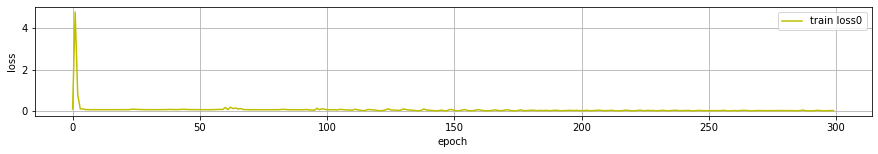

0  result :  0.024159491062164307


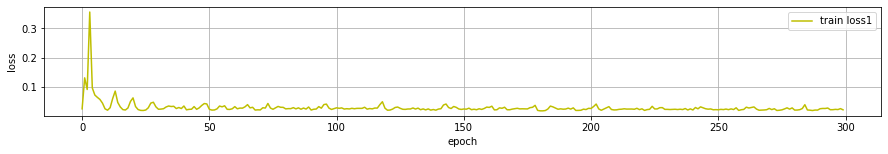

1  result :  0.03213076665997505


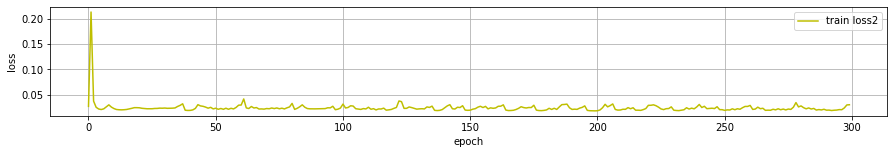

2  result :  0.02181261219084263


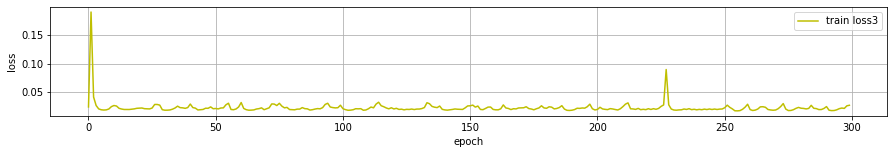

3  result :  0.024692459031939507


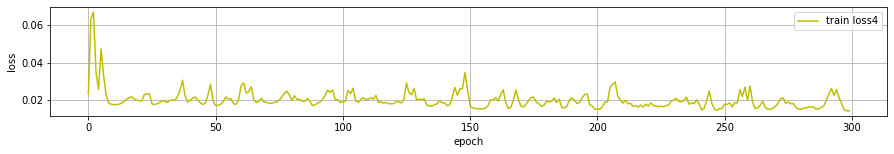

4  result :  0.01746593415737152


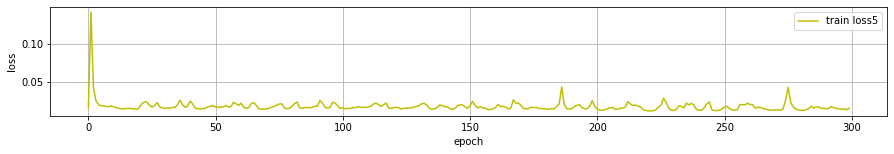

5  result :  0.02027870900928974


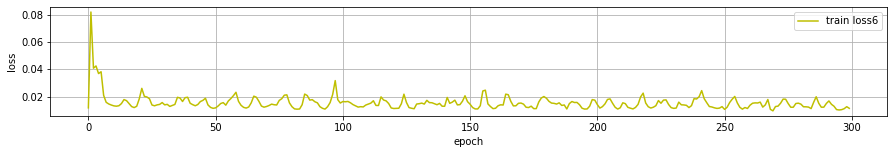

6  result :  0.01899278163909912


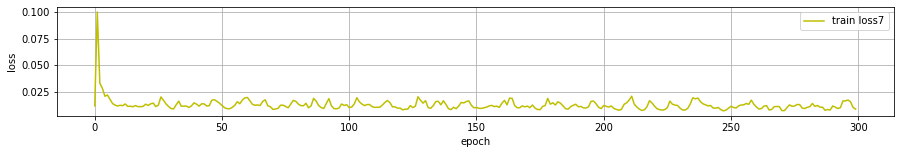

7  result :  0.020038770511746407


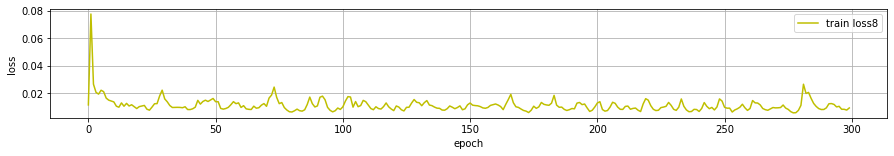

8  result :  0.020577505230903625


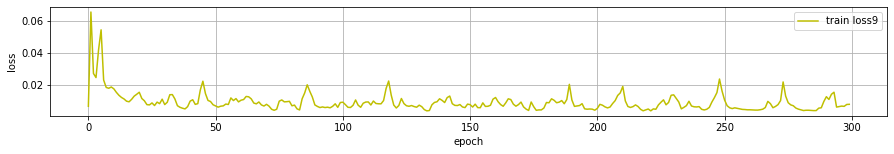

9  result :  0.023201987147331238


In [16]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 15
plt.rcParams["figure.figsize"] = (15,2)

for i in range(MODEL_NUM):
    fig, loss_ax = plt.subplots()
    loss_ax.grid()

    loss_ax.plot(histList[i].history['loss'], 'y', label='train loss'+str(i))
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')
    plt.show()
    print(i,' result : ', resultList[i])

# ###########################################################

# Load model해서 예측오차율 보기

In [3]:
modelList = []
for m in range(MODEL_NUM):
    modelList.append(load_model(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(m)+'.h5'))
    
X_train = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_trainX.npy")
y_train = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_trainY.npy")
X_test  = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_testX.npy")
y_test  = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_testY.npy")

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_test :  (8, 144, 17)
y_test :  (8, 48, 1)


# train _err rate

In [4]:
predErrRate_list = []
modelList = []
for n in range(MODEL_NUM):
    modelList.append(load_model(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(n)+'.h5'))

for n in range(MODEL_NUM):
    errRate = []
    y = pow_scaler.inverse_transform(y_train[:,:,0])
    plotY = y.reshape(-1,1)

    pred = modelList[n].predict(X_train)[:,:,0]
    pred[pred<0] = 0
    x = pow_scaler.inverse_transform(pred)
    plot_pred = x.reshape(-1,1)

    target_list=[]
    for i in range(0, plotY.shape[0], PRED_STEPS):
        for hr in range(0, PRED_STEPS):
            pred   = plot_pred[i+hr]
            target = plotY[i+hr]
            difference = np.abs(target-pred)
            errRate.append(np.round(difference/CAPACITY*100, 2))
            target_list.append(target)
            
    predErrRate_list.append(errRate)
    print(n," avg;",np.round(sum(predErrRate_list[n])/len(predErrRate_list[n]),2),end='')
    print(" \t max;",np.max(predErrRate_list[n]))
    
# save csv files    
print(np.shape(predErrRate_list))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+"2.csv",mode='w',index=False, encoding='CP949')

#histList_df = pd.DataFrame(histList).transpose()
#histList_df.to_csv(SAVE_PATH+"histList_"+SAVE_NAME+"2.csv",mode='w',index=False, encoding='CP949')

#resultList_df = pd.DataFrame(resultList).transpose()
#resultList_df.to_csv(SAVE_PATH+"resultList_"+SAVE_NAME+"2.csv",mode='w',index=False, encoding='CP949')

print("SAVE_NAME : ", SAVE_NAME)

0  avg; [9.15] 	 max; 58.7
1  avg; [11.3] 	 max; 58.53
2  avg; [5.71] 	 max; 61.44
3  avg; [5.69] 	 max; 51.64
4  avg; [4.66] 	 max; 39.07
5  avg; [4.57] 	 max; 39.85
6  avg; [3.36] 	 max; 26.7
7  avg; [2.84] 	 max; 22.58
8  avg; [3.09] 	 max; 36.99
9  avg; [1.33] 	 max; 13.16
(10, 1152, 1)
SAVE_NAME :  492951_1h_500e_128b


In [5]:
listsize = len(predErrRate_list[0])
count = []
column_names = ["0 < x < 6","(%)","6 < x < 8","(%)","8 < x < 10","(%)", "0 < x < 10","(%)",]
for m in range(MODEL_NUM):
    testList = predErrRate_list[m].copy()
    testList.sort()
    #count = sum(map(lambda x : x>5, listOfElems))
    count.append(int(sum(map(lambda x : x<6, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>6 and x < 8, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>8 and x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(np.round(sum(map(lambda x : x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    
countArr = np.array(count).reshape(10,-1)
countDf = pd.DataFrame(countArr, columns = column_names)
display(countDf)
#count2 = getCount(testList, lambda x : x>5 and x < 20)
#print("{} Model :\t{} \t({}%) \t{} \t({}%) \t{} \t({}%)  \t{} \t({}%)".format(m, int(count1), float(np.round(count1/listsize*100,2)),int(count2), float(np.round(count2/listsize*100,2)),int(count3), float(np.round(count3/listsize*100,2)),int(count4), float(np.round(count4/listsize*100,2))))

<ipython-input-5-e72e2604a92b>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  countArr = np.array(count).reshape(10,-1)


0 < x < 6    (%) 6 < x < 8   (%) 8 < x < 10   (%) 0 < x < 10      (%)
0       665  57.73        39  3.39         58  5.03      [762]  [66.15]
1       667   57.9        44  3.82         34  2.95      [745]  [64.67]
2       838  72.74        51  4.43         26  2.26      [916]  [79.51]
3       800  69.44        47  4.08         39  3.39      [888]  [77.08]
4       829  71.96        65  5.64         44  3.82      [938]  [81.42]
5       870  75.52        60  5.21         38   3.3      [969]  [84.11]
6       929  80.64        63  5.47         37  3.21     [1030]  [89.41]
7       983  85.33        54  4.69         42  3.65     [1081]  [93.84]
8       985   85.5        50  4.34         46  3.99     [1082]  [93.92]
9      1108  96.18        28  2.43          7  0.61     [1143]  [99.22]

TrainY: 48.0 일 ( 1152 시간)


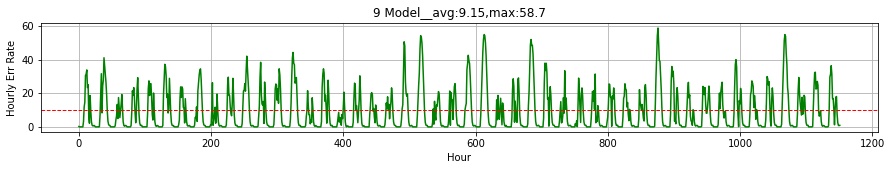

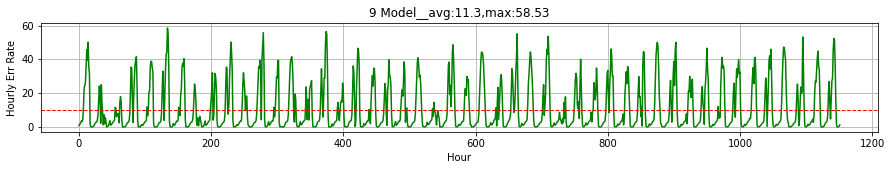

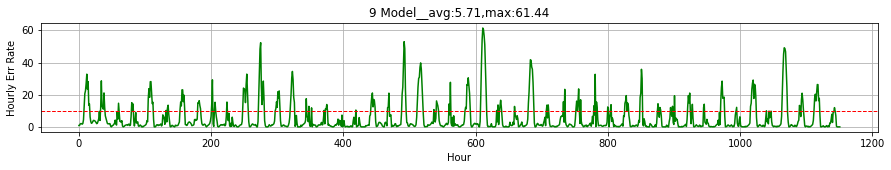

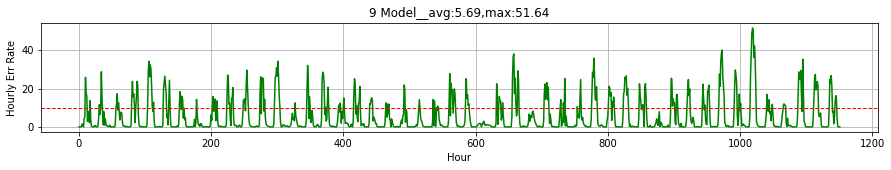

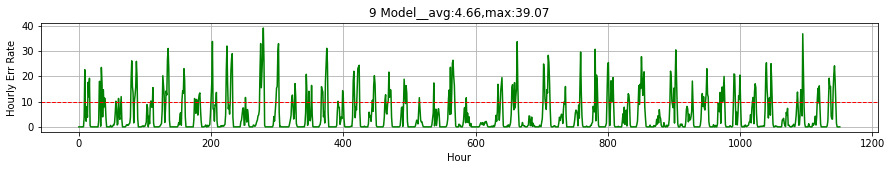

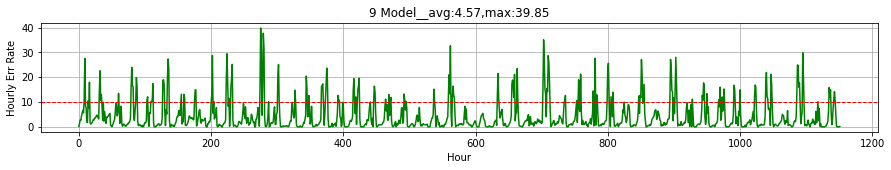

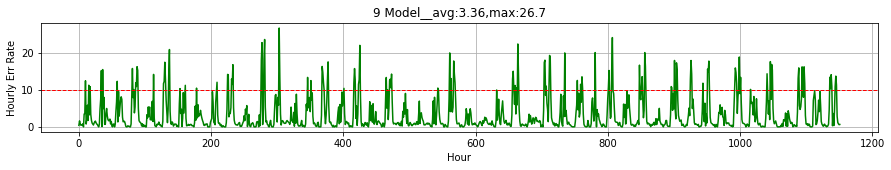

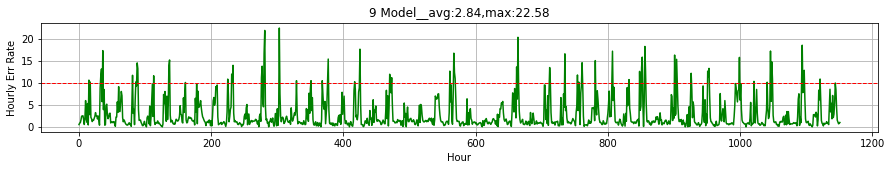

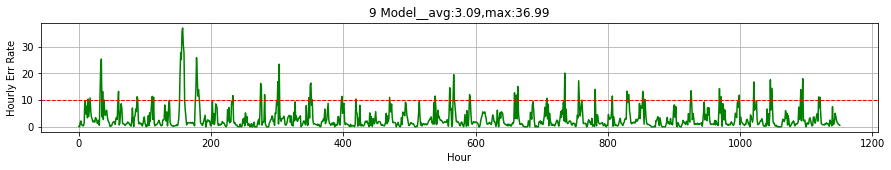

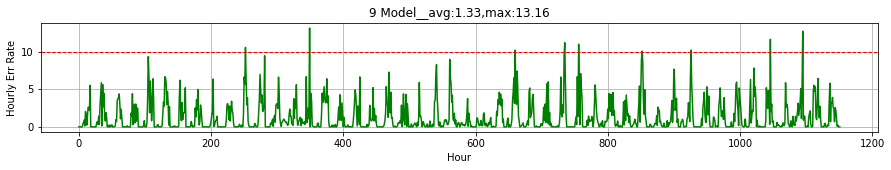

In [6]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for n in range(MODEL_NUM):
    #print("[ {} MODEL ] mean:{}, max:{}".format(n, np.round(np.mean(predErrRate_list[n]),3), np.max(predErrRate_list[n])))
    mean = np.round(np.mean(predErrRate_list[n]), 2)
    max  = np.round(np.max(predErrRate_list[n]), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,2)
    #plt.title("Hourly Err Rate(TrainY)")
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Hour')
    plt.ylabel('Hourly Err Rate')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_list[n], 'g-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

TrainY: 48.0 일 ( 1152 시간)


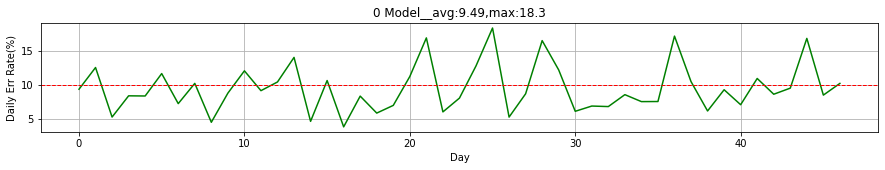

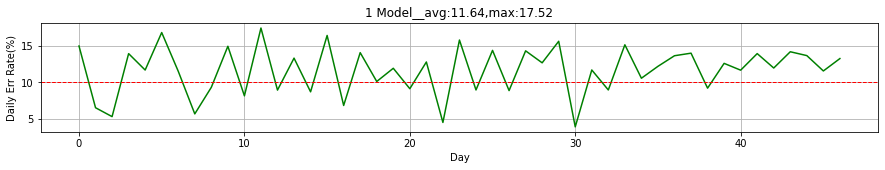

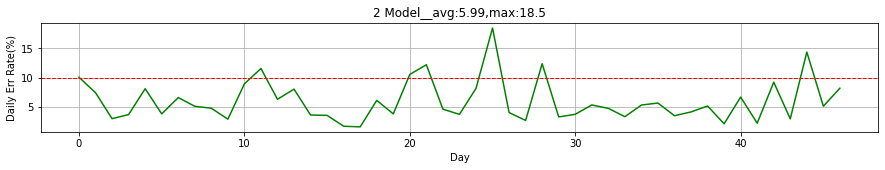

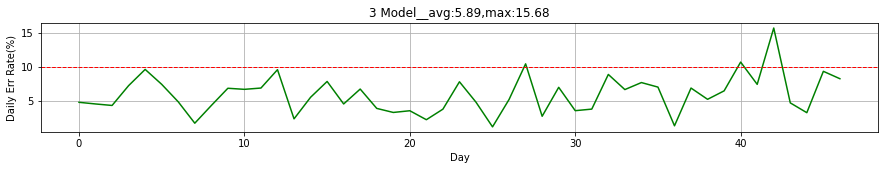

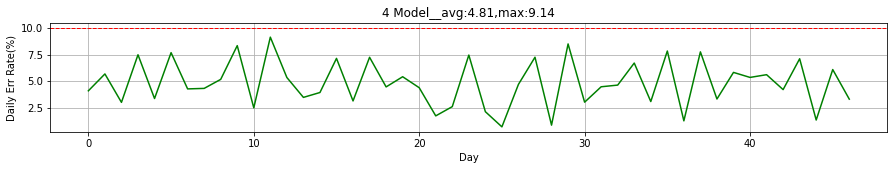

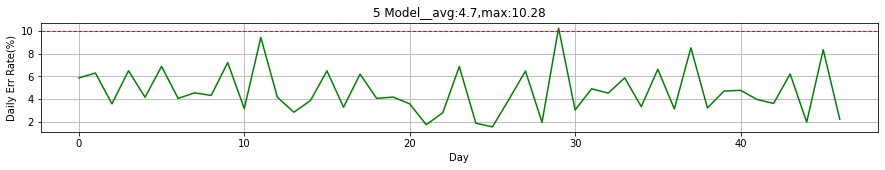

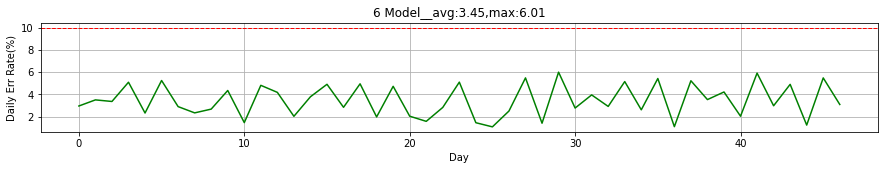

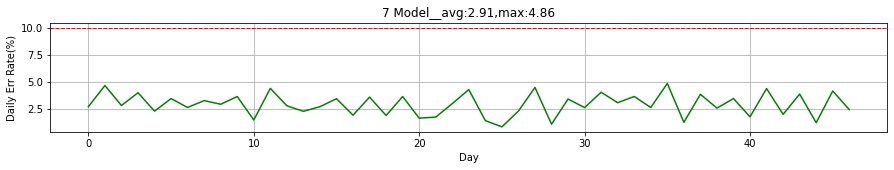

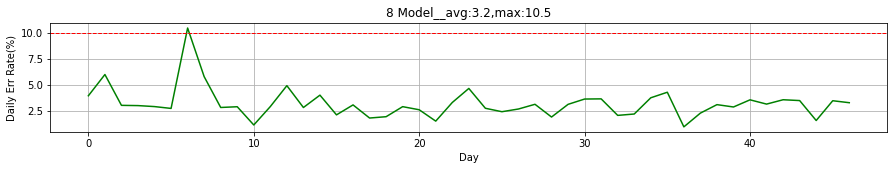

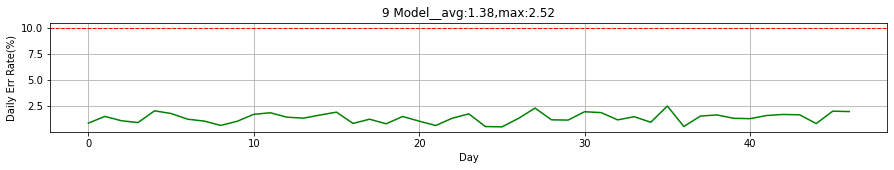

In [7]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for m in range(MODEL_NUM):
    dailyErrRate = []
    for i in range(0, plotY.shape[0]-HOUR_STEPS, HOUR_STEPS):
        dailyErrRate.append(np.mean(predErrRate_list[m][i:i+HOUR_STEPS-1]))
    mean = np.round(np.mean(dailyErrRate), 2)
    max  = np.round(np.max(dailyErrRate), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams['font.size'] = 10
    plt.rcParams["figure.figsize"] = (15,2)
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Day')
    plt.ylabel('Daily Err Rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(dailyErrRate, 'g-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

# TEST _err rate

In [8]:
n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
predictModel = []
predList=[]
predErrRate_list=[]
yList=[]
print(n_dataset)

print("[ model ]")
for m in range(MODEL_NUM):
    errRate=[]
    print("-"*70,"[ model {} ]".format(m))
#for m in range(2):
    plot_target=[]
    plot_predict=[]
    for i in range(n_dataset):
        #print("(dataset {}) : ".format(i), end='')
    #for i in range(5):
    #if(i in [2,3,4,5,6,7,8]): continue;
        y = pow_scaler.inverse_transform(y_test[i:i+1,:,0])
        yList = y.reshape(-1,1)

        pred = modelList[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = pow_scaler.inverse_transform(pred)
        predSum = np.sum(pred)
        predList = pred.reshape(-1,1)

        target_list=[]
        for i in range(0, yList.shape[0], PRED_STEPS):
            for hr in range(0, PRED_STEPS):
                pred   = predList[i+hr]
                target = yList[i+hr]
                difference = np.abs(target-pred)
                errRate.append(np.round(difference/CAPACITY*100, 2))
                target_list.append(target)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-predSum), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
        #predErrRateTest_AllModel.append(predErrRateTest)
        print(np.round(np.mean(acc_list[-MODEL_NUM:]),2), " / ",sep='',end='')
        
    predErrRate_list.append(errRate)
    print(" \tErr Rate avg;",np.round(sum(predErrRate_list[m])/len(predErrRate_list[m]),2),end='')
    print(" \t max;",np.max(predErrRate_list[m]))

print("\npredErrRate_list:{}".format(np.shape(predErrRate_list)))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+"_TEST333.csv",mode='w',index=False, encoding='CP949')
print("----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
#for m in range(MODEL_NUM):
    #print(predErrRateTest_AllModel[m])
    #acc_model[i] = round(acc_model[i]/(n_dataset),2)
    #print(acc_model[i])

8
[ model ]
---------------------------------------------------------------------- [ model 0 ]
77.0 / 74.0 / 82.0 / 85.75 / 83.2 / 81.67 / 79.0 / 81.38 /  	Err Rate avg; [9.47] 	 max; 58.96
---------------------------------------------------------------------- [ model 1 ]
79.33 / 80.8 / 82.2 / 83.1 / 79.4 / 76.1 / 77.3 / 79.0 /  	Err Rate avg; [11.75] 	 max; 60.54
---------------------------------------------------------------------- [ model 2 ]
80.5 / 78.1 / 81.0 / 80.2 / 78.5 / 78.4 / 78.3 / 81.8 /  	Err Rate avg; [7.23] 	 max; 61.37
---------------------------------------------------------------------- [ model 3 ]
77.3 / 72.4 / 72.4 / 67.4 / 65.0 / 60.9 / 59.2 / 58.9 /  	Err Rate avg; [11.92] 	 max; 65.52
---------------------------------------------------------------------- [ model 4 ]
57.7 / 53.4 / 58.6 / 56.4 / 56.3 / 59.6 / 58.5 / 63.5 /  	Err Rate avg; [10.21] 	 max; 62.98
---------------------------------------------------------------------- [ model 5 ]
63.7 / 62.8 / 67.7 / 68

In [9]:
listsize = len(predErrRate_list[0])
count = []
column_names = ["0 < x < 6","(%)","6 < x < 8","(%)","8 < x < 10","(%)", "0 < x < 10","(%)",]
for m in range(MODEL_NUM):
    testList = predErrRate_list[m].copy()
    testList.sort()
    #count = sum(map(lambda x : x>5, listOfElems))
    count.append(int(sum(map(lambda x : x<6, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>6 and x < 8, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>8 and x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(np.round(sum(map(lambda x : x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    
countArr = np.array(count).reshape(10,-1)
countDf = pd.DataFrame(countArr, columns = column_names)
display(countDf)

print("0 < x < 10 (%) : AVG {} \t MIN {} \t MAX {}".format(np.mean(countDf.iloc[:,-1]), np.min(countDf.iloc[:,-1]), np.max(countDf.iloc[:,-1])))
#count2 = getCount(testList, lambda x : x>5 and x < 20)
#print("{} Model :\t{} \t({}%) \t{} \t({}%) \t{} \t({}%)  \t{} \t({}%)".format(m, int(count1), float(np.round(count1/listsize*100,2)),int(count2), float(np.round(count2/listsize*100,2)),int(count3), float(np.round(count3/listsize*100,2)),int(count4), float(np.round(count4/listsize*100,2))))

<ipython-input-9-c554454eb602>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  countArr = np.array(count).reshape(10,-1)


0 < x < 6    (%) 6 < x < 8   (%) 8 < x < 10   (%) 0 < x < 10      (%)
0       219  57.03        23  5.99         14  3.65      [256]  [66.67]
1       216  56.25         8  2.08         14  3.65      [238]  [61.98]
2       235   61.2        18  4.69         23  5.99      [277]  [72.14]
3       222  57.81        12  3.12         12  3.12      [246]  [64.06]
4       237  61.72         6  1.56         17  4.43      [261]  [67.97]
5       243  63.28        11  2.86         13  3.39      [267]  [69.53]
6       240   62.5        21  5.47         18  4.69      [279]  [72.66]
7       244  63.54        15  3.91         16  4.17      [275]  [71.61]
8       240   62.5        13  3.39         14  3.65      [267]  [69.53]
9       240   62.5         9  2.34         10   2.6      [260]  [67.71]

0 < x < 10 (%) : AVG [68.386] 	 MIN [61.98] 	 MAX [72.66]


TrainY: 16.0 일 ( 384 시간)


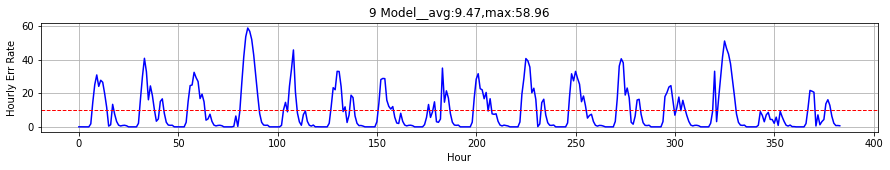

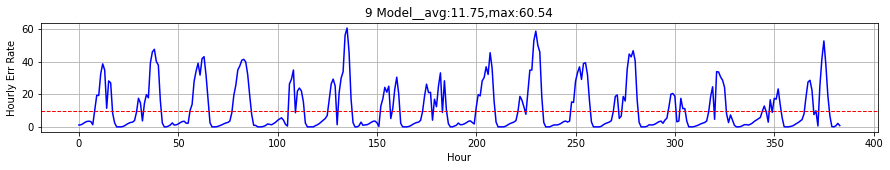

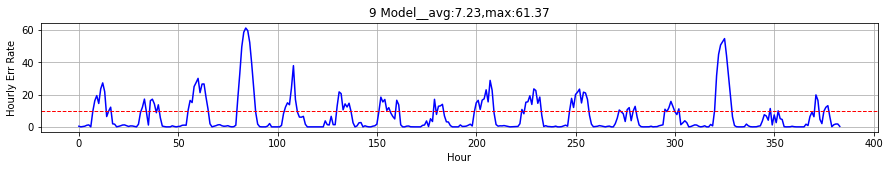

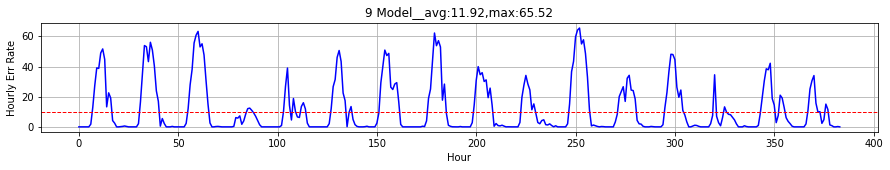

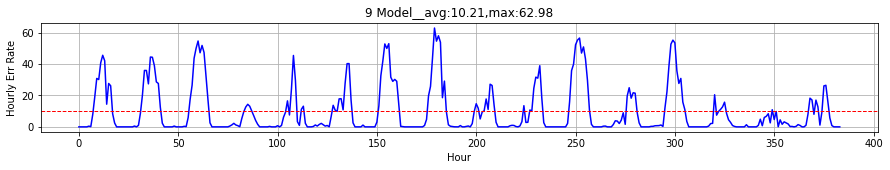

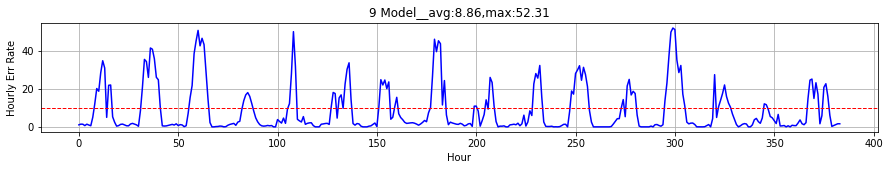

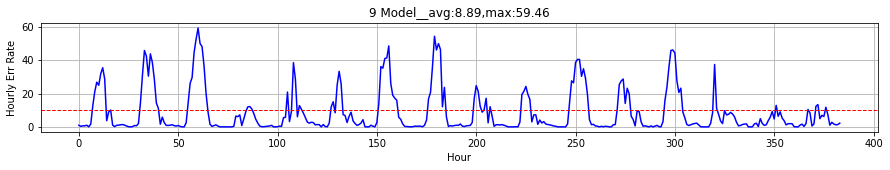

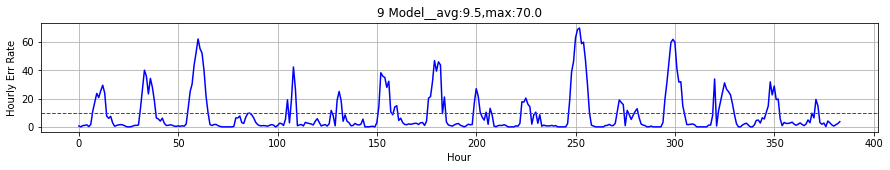

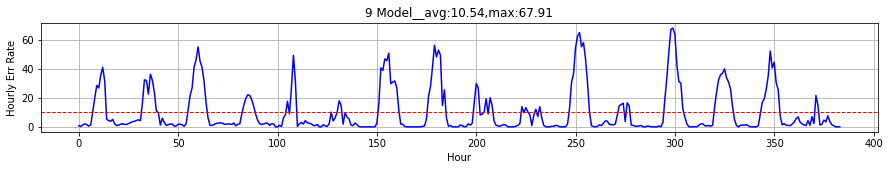

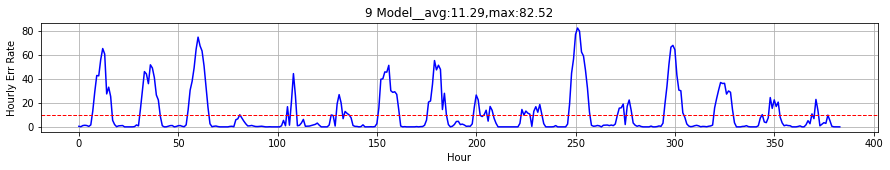

In [10]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for n in range(MODEL_NUM):
    #print("[ {} MODEL ] mean:{}, max:{}".format(n, np.round(np.mean(predErrRate_list[n]),3), np.max(predErrRate_list[n])))
    mean = np.round(np.mean(predErrRate_list[n]), 2)
    max  = np.round(np.max(predErrRate_list[n]), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,2)
    #plt.title("Hourly Err Rate(TrainY)")
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Hour')
    plt.ylabel('Hourly Err Rate')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_list[n], 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

TrainY: 16.0 일 ( 384 시간)


c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


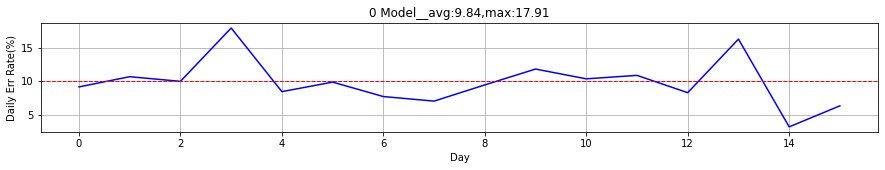

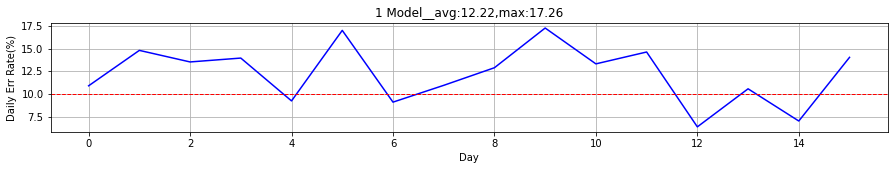

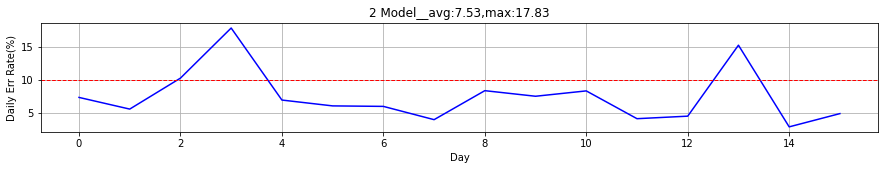

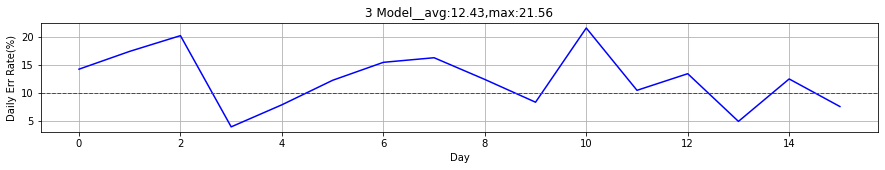

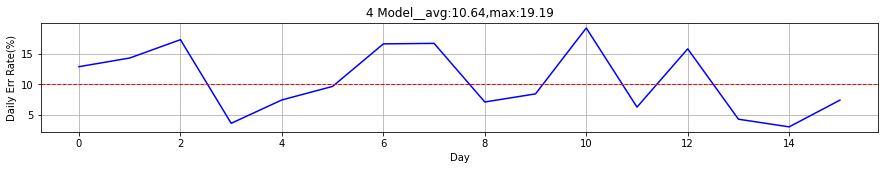

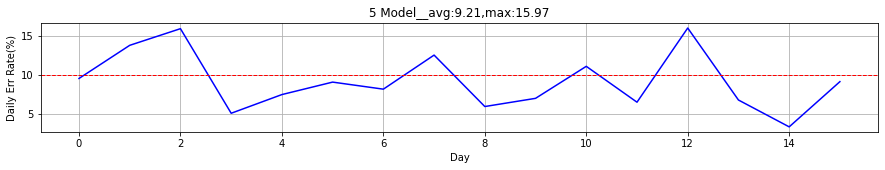

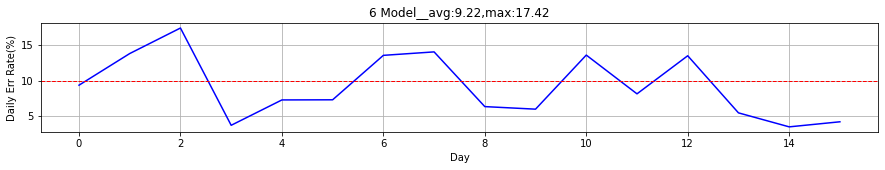

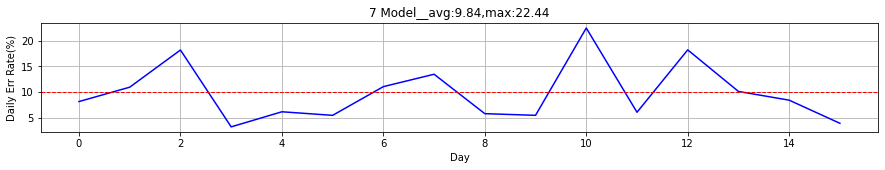

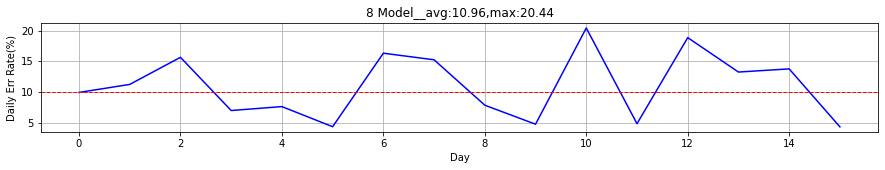

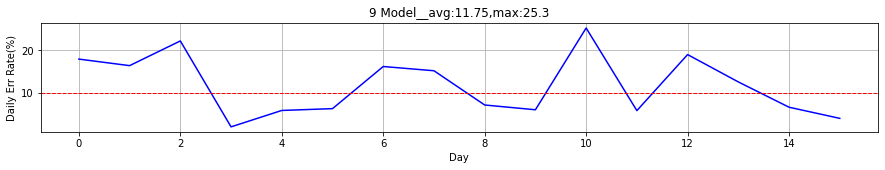

In [11]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for m in range(MODEL_NUM):
    dailyErrRate = []
    for i in range(0, plotY.shape[0]-HOUR_STEPS, HOUR_STEPS):
        dailyErrRate.append(np.mean(predErrRate_list[m][i:i+HOUR_STEPS-1]))
        
    dailyErrRate = [x for x in dailyErrRate if np.isnan(x) == False]
    mean = np.round(np.mean(dailyErrRate), 2)
    max  = np.round(np.max(dailyErrRate), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams['font.size'] = 10
    plt.rcParams["figure.figsize"] = (15,2)
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Day')
    plt.ylabel('Daily Err Rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(dailyErrRate, 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

In [12]:
plt.rcParams['font.size'] = 20
y = pow_scaler.inverse_transform(y_test[:,:,0])
plotY = y.reshape(-1,1)
print("step: ",plotY.shape[0])
print(int(plotY.shape[0]/HOUR_STEPS))

step:  384
16


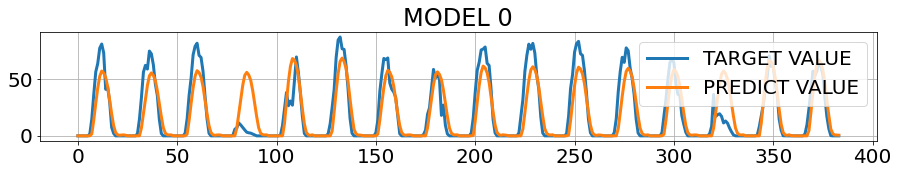

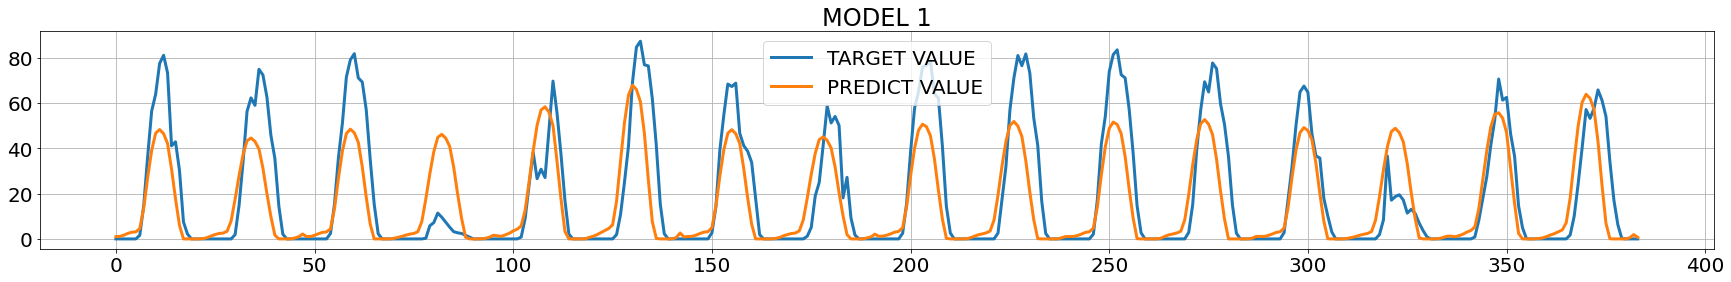

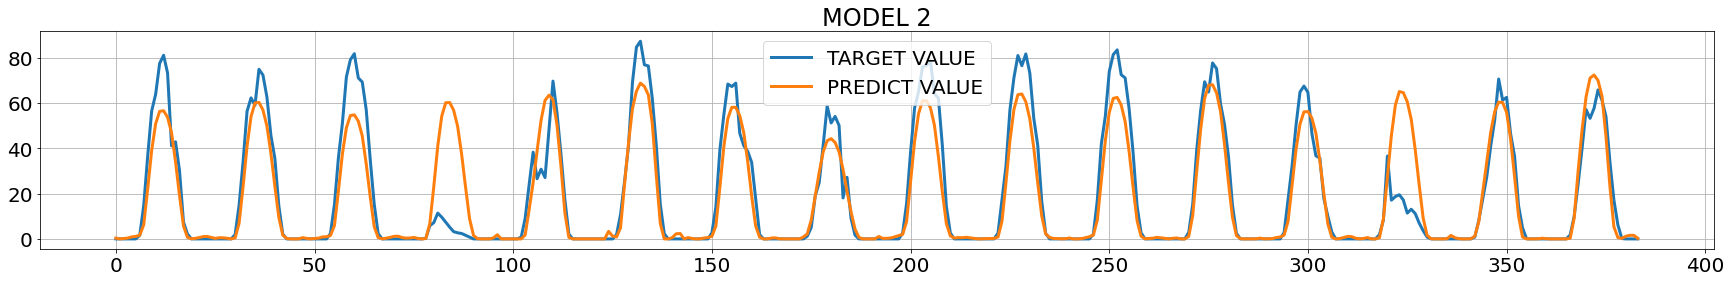

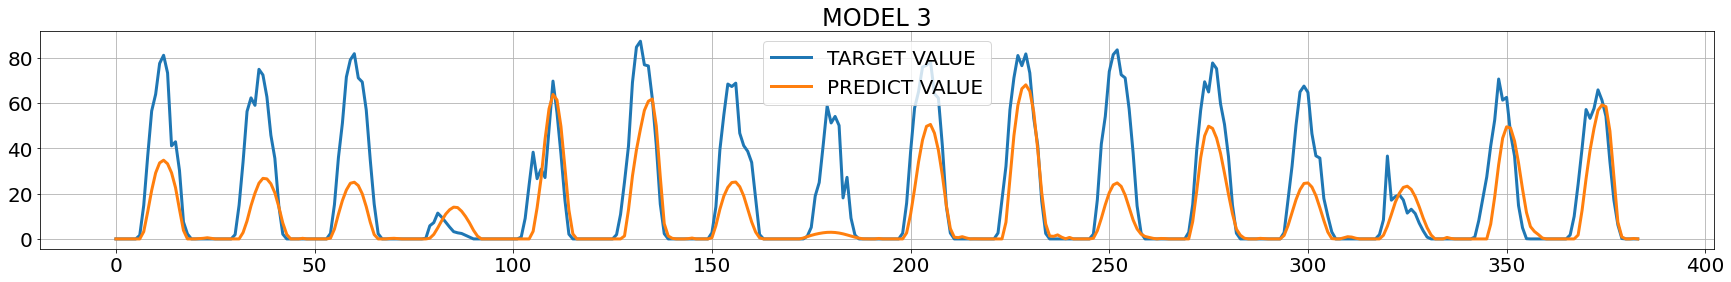

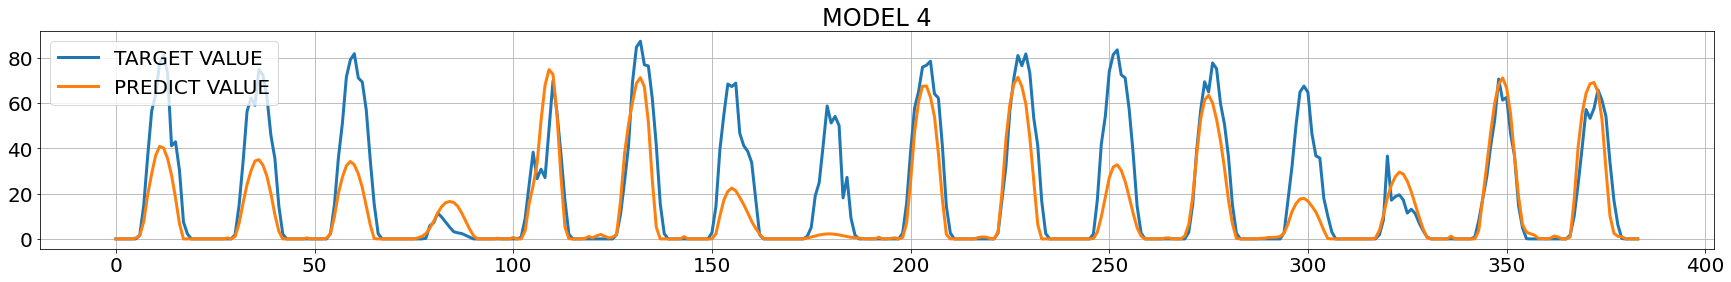

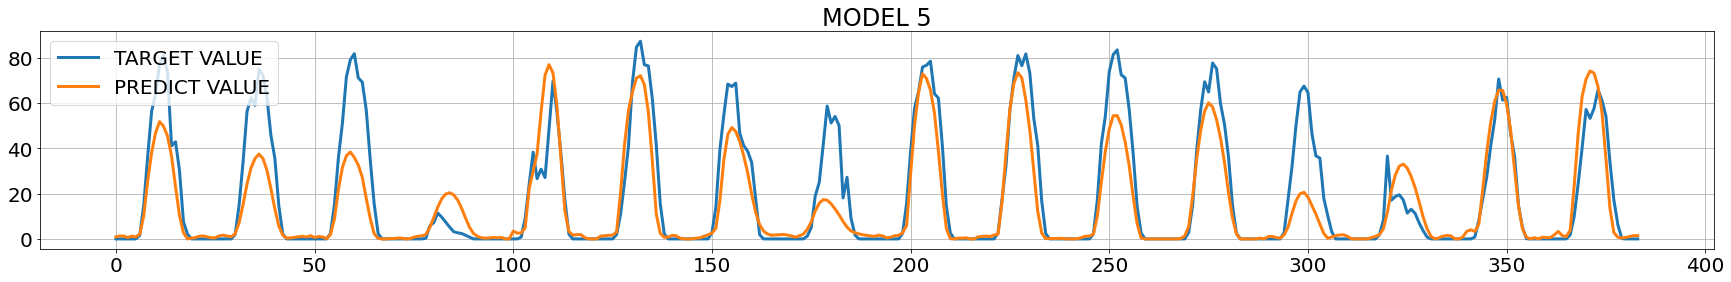

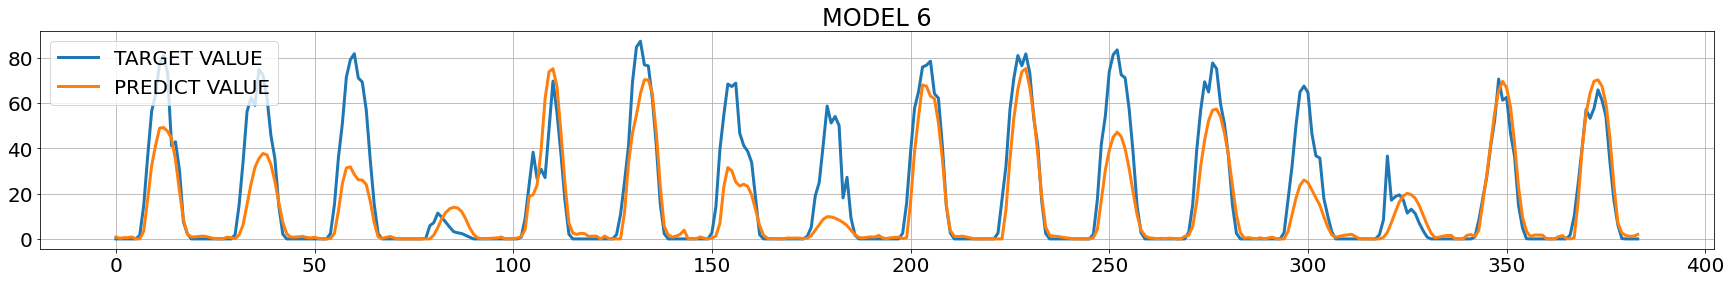

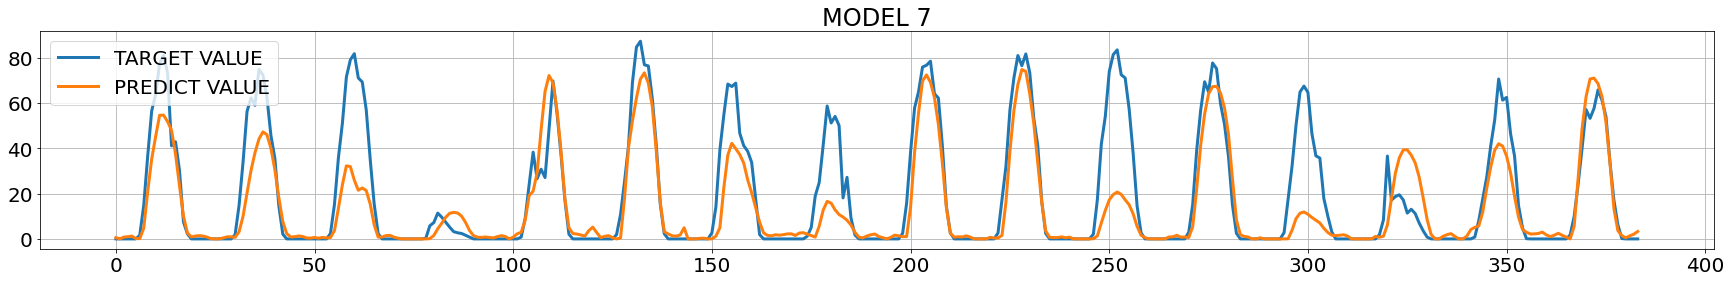

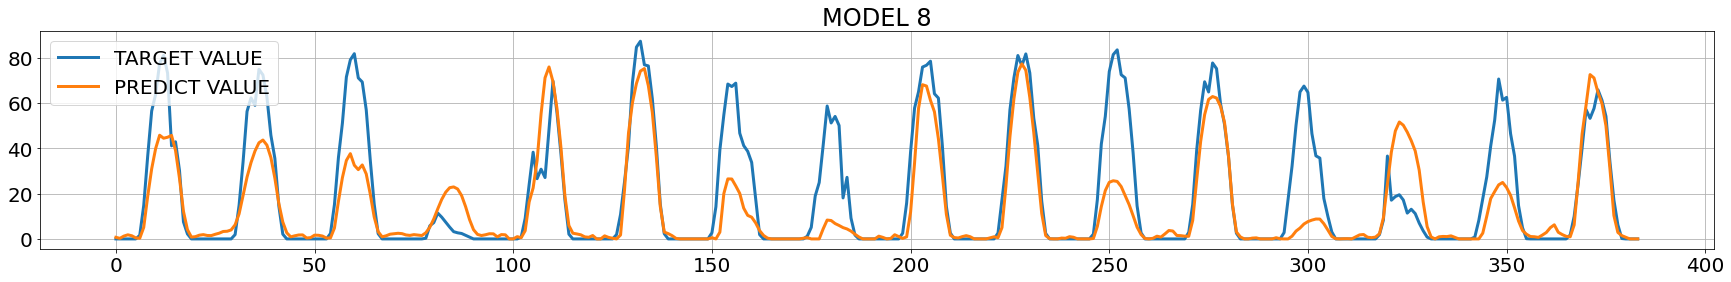

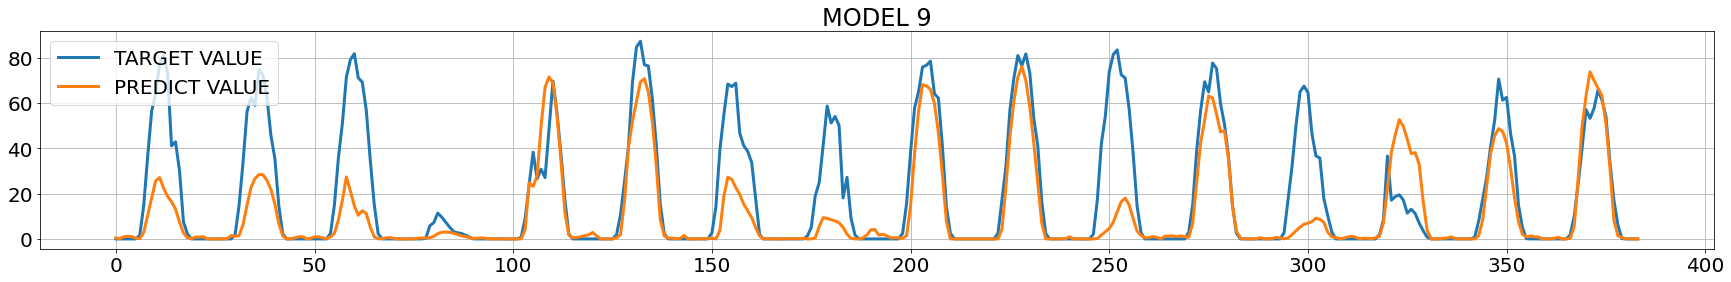

In [13]:
y = pow_scaler.inverse_transform(y_test[:,:,0])
plotY = y.reshape(-1,1)
step = int(plotY.shape[0])

for m in range(MODEL_NUM):
    pred = modelList[m].predict(X_test)[:,:,0]
    pred[pred<0] = 0

    x = pow_scaler.inverse_transform(pred)
    plotY_pred = x.reshape(-1,1)

    acc_list = []
    target_list=[]

    for i in range(0, plotY.shape[0]-step+1, step):
        plt.title("MODEL "+str(m))
        plt.rcParams["figure.figsize"] = (30,4)
        plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
        plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()

In [20]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)
plotY_pred[plotY_pred<0] = 0

step = hoursteps*7 #timesteps#
print(plotY.shape[0],'-',step)
for i in range(0, plotY.shape[0]-step, step):
    plt.rcParams["figure.figsize"] = (25,4)
    plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
    plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
    #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
    #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
    plt.grid()
    plt.legend()
    plt.show()


NameError: name 'trainY' is not defined

# 여기 위에까지~

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


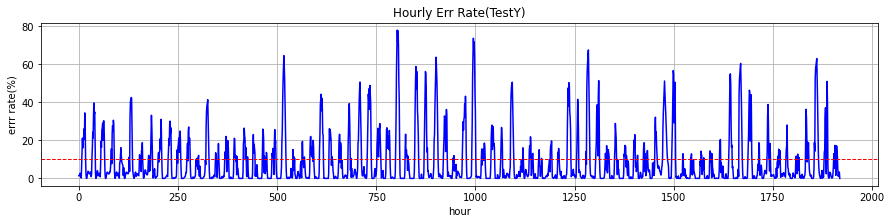

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


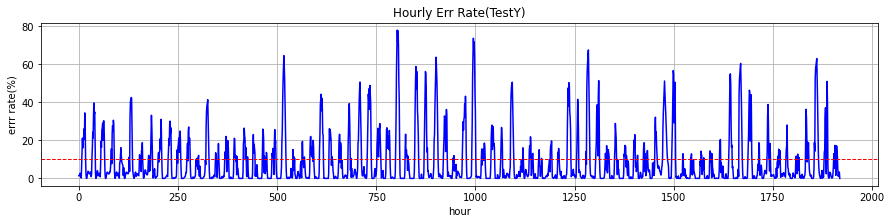

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


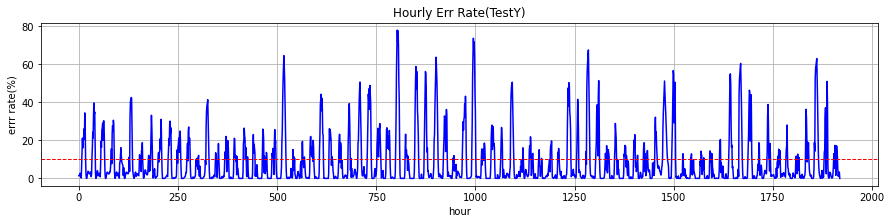

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


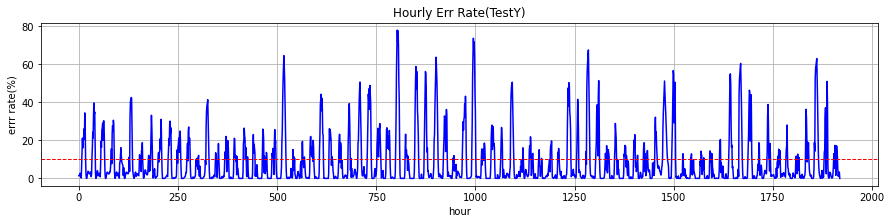

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


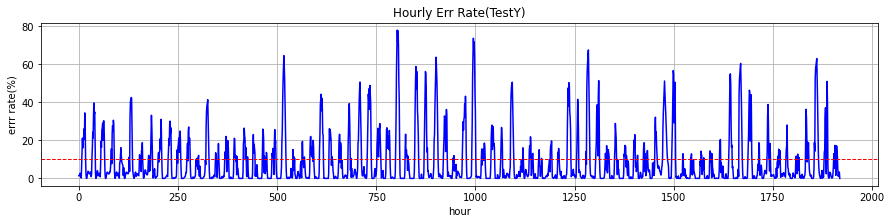

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


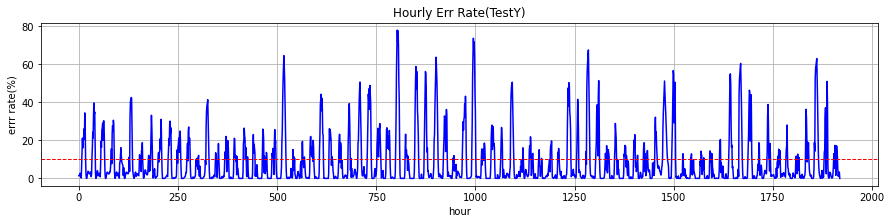

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


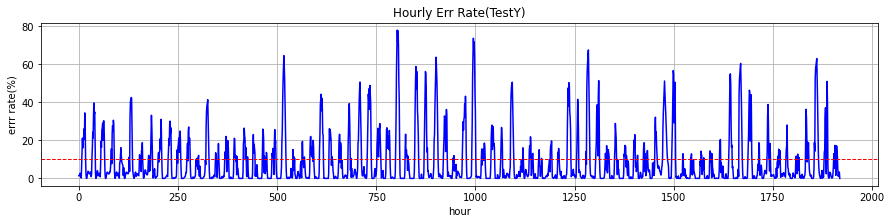

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


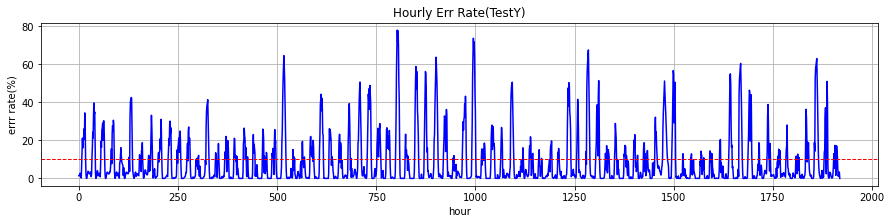

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


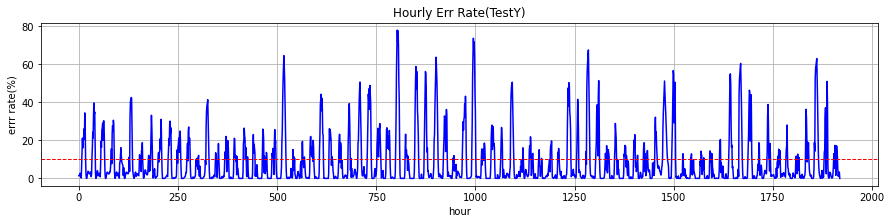

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


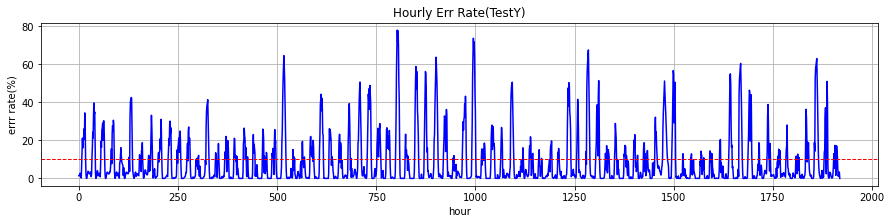

In [37]:
for n in range(MODEL_NUM):
    print("test data : ", np.rint(np.shape(predErrRate_All[n])[0]/PRED_STEPS),"일 (", np.shape(predErrRate_All[n])[0],"시간)",)
    print("mean(err rate): ",np.round(np.mean(predErrRate_All[n]),3),sep='')
    print(" max(err rate): ",np.max(predErrRate_All[n]),sep='')

    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,3)
    plt.title("Hourly Err Rate(TestY)")
    plt.xlabel('hour')
    plt.ylabel('errr rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_All[n], 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

In [13]:
show_shapes()
print(np.shape(trainY), type(trainY))

Expected: (num_samples, timesteps, channels)
trainX:float64	 (28, 144, 17) 	/ float64	 (28, 48, 1)
valX:  float64	 (8, 144, 17) 	/ float64	 (8, 48, 1)
testX: float64	 (4, 144, 17) 	/ float64	 (4, 48, 1)
(28, 48, 1) <class 'numpy.ndarray'>


In [ ]:
#modelList = []
#modelList.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))

for i in range(MODEL_NUM):
    plotY = trainY.reshape(-1,1)
    plotY_pred = modelList[i].predict(trainX).reshape(-1,1)
    plotY_pred[plotY_pred<0] = 0

    step = hoursteps*7
    print(plotY.shape[0],'-',step)
    for i in range(0, plotY.shape[0]-step, step):
        plt.rcParams["figure.figsize"] = (25,4)
        plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
        plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
        #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
        #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()


In [46]:
modelList = []
modelList.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))

for i in range(MODEL_NUM):
    plotY = trainY.reshape(-1,1)
    plotY_pred = modelList[i].predict(trainX).reshape(-1,1)
    plotY_pred[plotY_pred<0] = 0

    step = hoursteps*7
    print(plotY.shape[0],'-',step)
    for i in range(0, plotY.shape[0]-step, step):
        plt.rcParams["figure.figsize"] = (25,4)
        plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
        plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
        #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
        #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()


NameError: name 'load_model' is not defined

step:  1008
MODEL  0


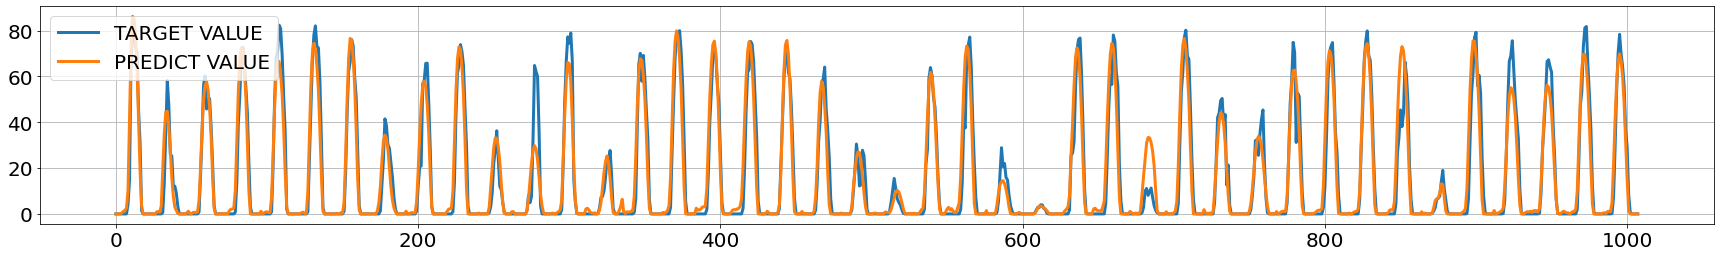

MODEL  1


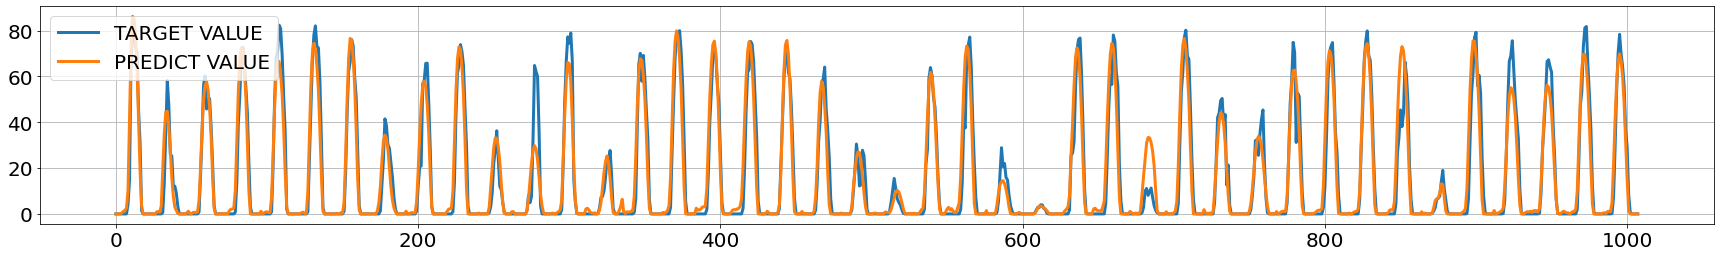

MODEL  2


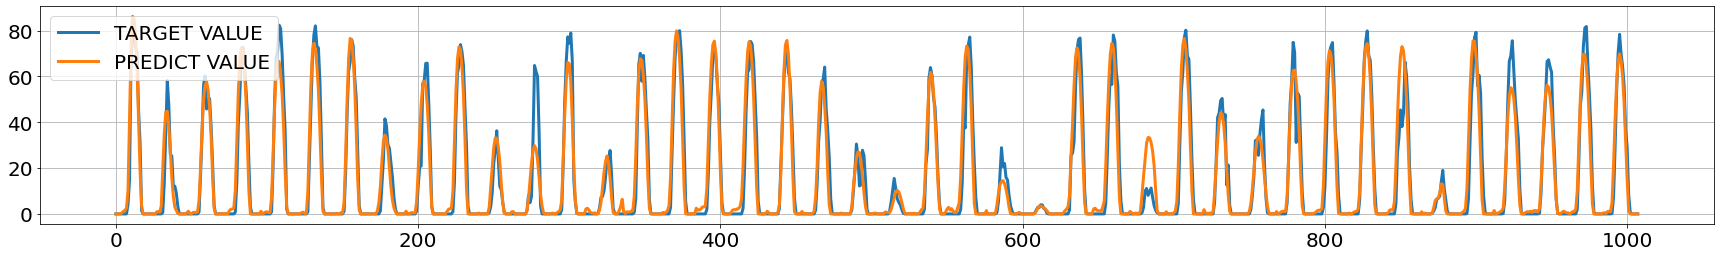

MODEL  3


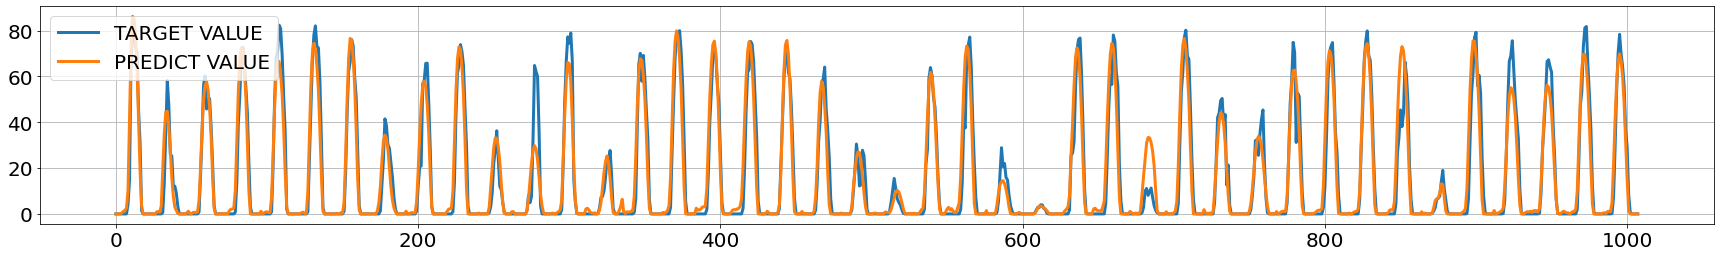

MODEL  4


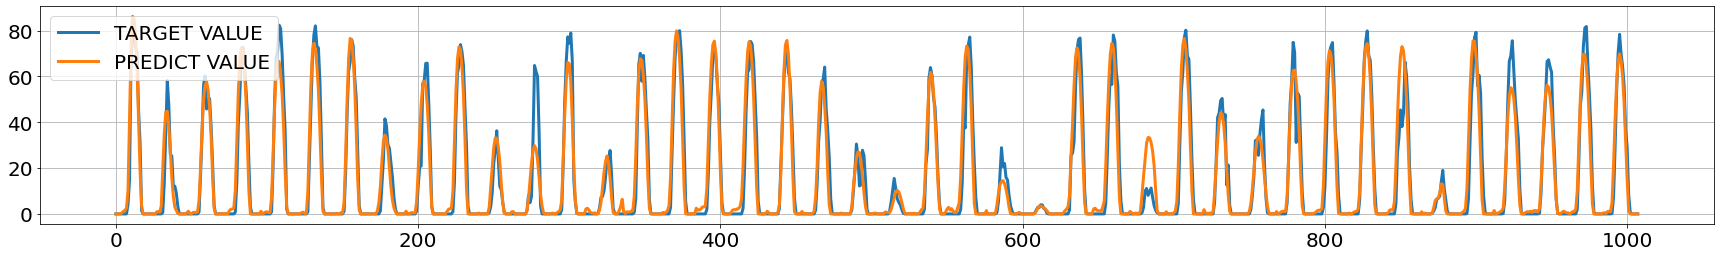

MODEL  5


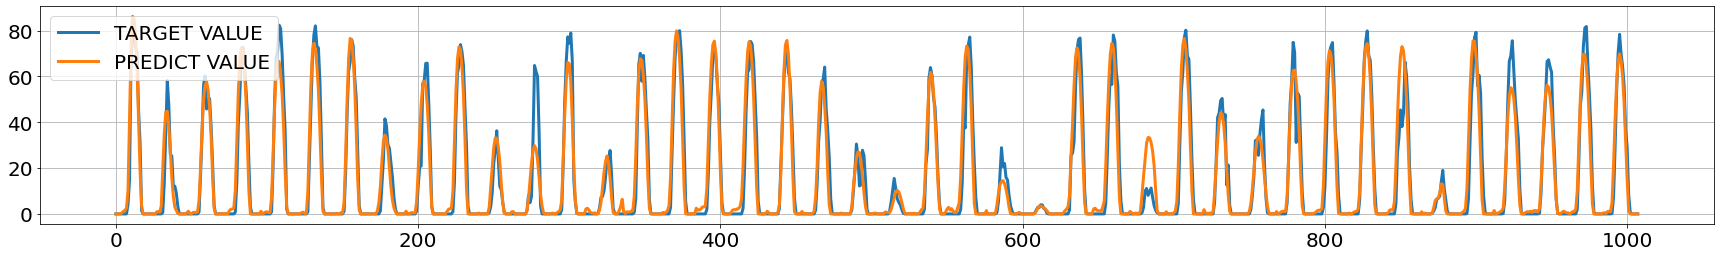

MODEL  6


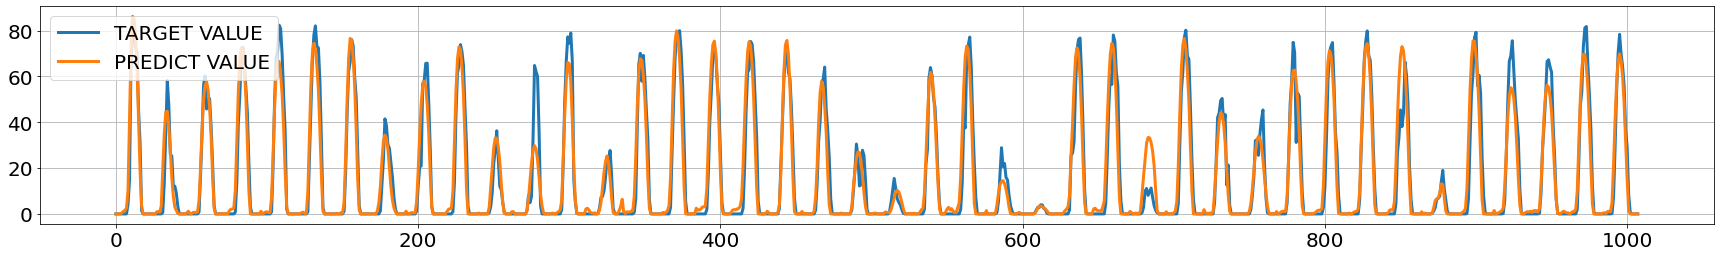

MODEL  7


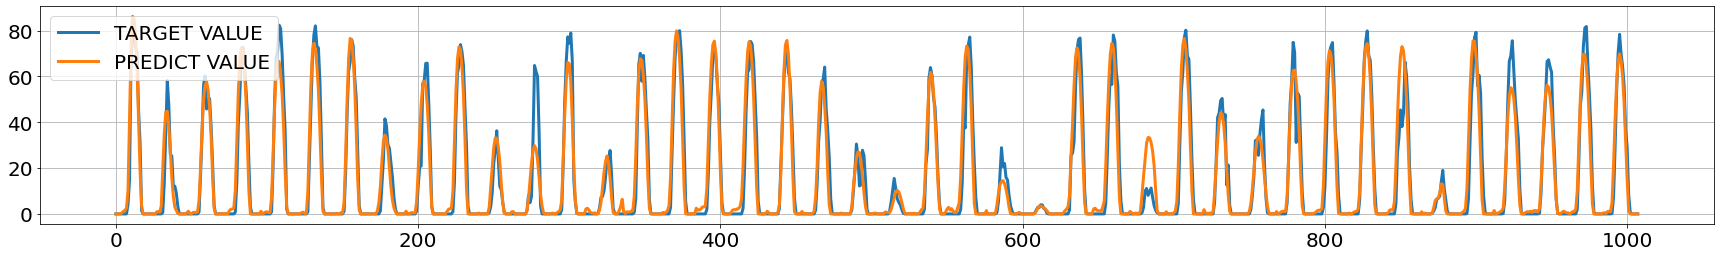

MODEL  8


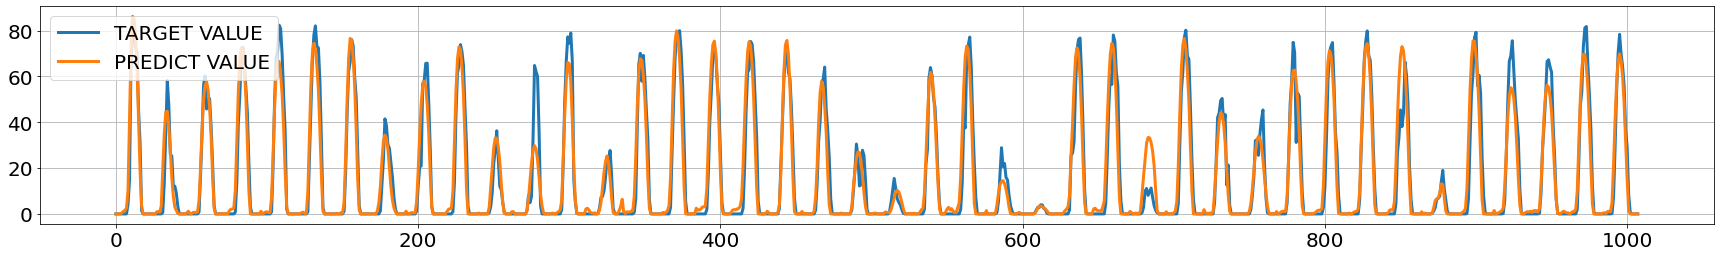

MODEL  9


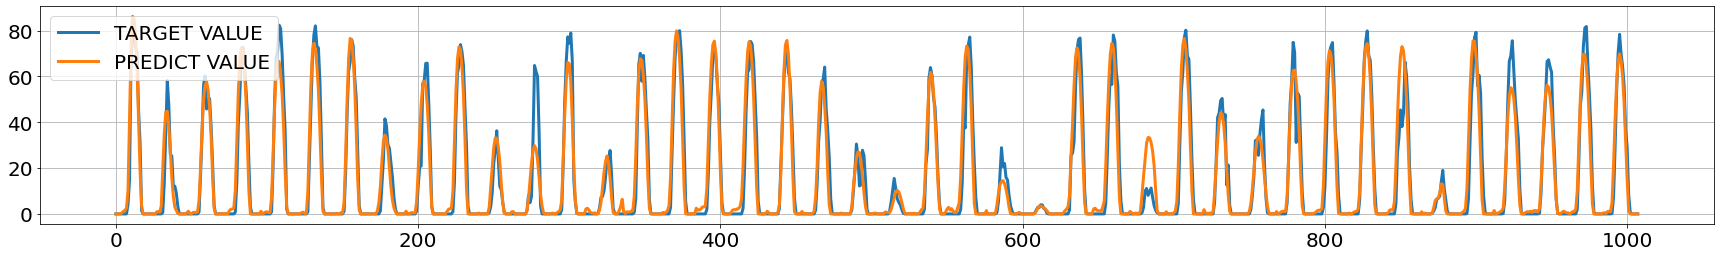

In [37]:
plt.rcParams['font.size'] = 20
y = pow_scaler.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)
print("step: ",hoursteps*21)


for i in range(MODEL_NUM):
    print("MODEL ",i)
    pred = modelList[i].predict(trainX)[:,:,0]
    pred[pred<0] = 0

    x = pow_scaler.inverse_transform(pred)
    plotY_pred = x.reshape(-1,1)

    acc_list = []
    target_list=[]

    step = hoursteps*21
    for i in range(0, plotY.shape[0]-step, step):
    #for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    #for i in range(0, 240-step, step):
        plt.rcParams["figure.figsize"] = (30,4)
        plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
        plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
        #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
        #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()

    #plt.tight_layout()
    #plt.savefig(save_path+'/predict.jpg')
    #plt.show()
    #print(plotY_pred)

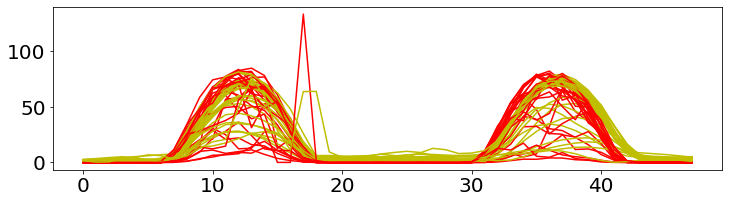

In [20]:
y = pow_scaler.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
pred[pred<0] = 0

x = pow_scaler.inverse_transform(pred)
plot_pred = x.reshape(-1,1)

acc_list = []
target_list=[]
predErrRate_list = []

for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.plot(plotY[i:i+hoursteps], 'r-', label="target")
    plt.plot(plot_pred[i:i+hoursteps], 'y-', label="output")
    #plt.legend()
    #plt.show()
    
    pred = np.sum(plot_pred[i:i+hoursteps])
    target      = round(np.sum(plotY[i:i+hoursteps]), 2)
    
    error       = round(np.abs(target-pred), 2)
    error_rate  = round(error/target, 2)
    acc_rate    = np.max([round((1.0-error_rate)*100, 2),0])
    
    
    predErrRate = round(np.abs((target-pred)/920.2*100), 2)
    predErrRate_list.append(predErrRate)
    
    target_list.append(target)
    acc_list.append(acc_rate)
    #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")

mean(acc rate): 76.70370370370371


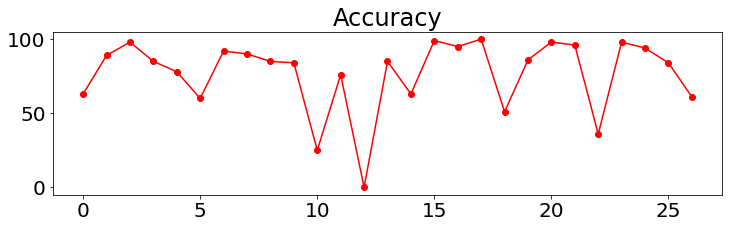

[63.0, 89.0, 98.0, 85.0, 78.0, 60.0, 92.0, 90.0, 85.0, 84.0, 25.0, 76.0, 0.0, 85.0, 63.0, 99.0, 95.0, 100.0, 51.0, 86.0, 98.0, 96.0, 36.0, 98.0, 94.0, 84.0, 61.0]


In [21]:
print("mean(acc rate): ",np.mean(acc_list),sep='')
    
#plotAcc = np.array(acc_list).reshape(-1,1)
plt.plot(acc_list, 'ro-')
plt.title("Accuracy")
plt.rcParams["figure.figsize"] = (12,3)
plt.show()
print(acc_list)

# Test dataset